In [1]:
import pandas as pd, numpy as np
import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from datetime import datetime, timedelta
os.getcwd()
# Add parent path for import
from forecast_dataloader import ForecastDataset, de_normalized
pd.set_option('display.max_columns', 50)

/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but

In [2]:
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)

WINDOW_SIZE = 24
HORIZON = 6
NORM_METHOD = 'z_score'
DATASET = 'New York'
START_POI = 0
END_POI = 40
BATCH_SIZE = 1
START_DATE = '2018-12-31'

TOTAL_DAYS = 400

In [3]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)

train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days

time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
test_dates = time_span[(train_days + valid_days)*24 + WINDOW_SIZE: - HORIZON + 1]

/tmp/ipykernel_9098/2841897662.py:9: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()


In [4]:
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/bysgnn_orig')
df = pd.read_pickle(f'cache_data/data-{START_POI}-{END_POI}-{TOTAL_DAYS}-{DATASET}.pkl')
# df = df.iloc[START_POI:END_POI]

data = pd.DataFrame(df["visits_by_each_hour"].to_list()).T

# split data
days = int(data.shape[0] / 24)

train_days = int(TRAIN_RATIO * days)
valid_days = int(days*VALID_RATIO)
test_days = days-train_days-valid_days

train_data = data[:train_days*24]
valid_data = data[train_days*24:(train_days + valid_days)*24]
test_data = data[(train_days + valid_days)*24:(train_days + valid_days+test_days)*24]

with open(os.path.join(f'output/{DATASET}/train_{START_POI}_{END_POI}', 'norm_stat.json'),'r') as f:
    normalize_statistic = json.load(f)


test_set = ForecastDataset(test_data, window_size=WINDOW_SIZE, 
                            horizon=HORIZON,
                            normalize_method=NORM_METHOD, 
                            norm_statistic=normalize_statistic)

test_loader = torch_data.DataLoader(test_set, batch_size=BATCH_SIZE, drop_last=False,
                                    shuffle=False, num_workers=0)

valid_set = ForecastDataset(valid_data, window_size=WINDOW_SIZE, horizon=HORIZON,
                            normalize_method=NORM_METHOD, norm_statistic=normalize_statistic)
valid_loader = torch_data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
model_orig_adj = torch.load(f'output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/attention_adj')
model_att_adj = torch.load(f'output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/dist_adj')
model_dist_adj = torch.load(f'output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/semantics_adj')
model_semantics_adj = torch.load(f'output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph_adj_interpretation/')

In [5]:
def get_sample_by_datetime(datetime_str, test_dates, test_loader):
    datetime_input = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
    datetime_input_np = np.datetime64(datetime_input)

    for i, data in enumerate(test_loader):
        if test_dates[i] == datetime_input_np:
            return data
    raise ValueError("Datetime not found in test_dates array.")

### Wednesday, Jan 22, 2020 10:00:00 AM (Lunch time in weekday)

In [6]:
x, y = get_sample_by_datetime('2020-01-22 10:00:00', test_dates, test_loader)
x.shape, y.shape

(torch.Size([1, 24, 50]), torch.Size([1, 6, 50]))

In [7]:
model_orig_adj.eval()
model_att_adj.eval()
model_dist_adj.eval()
model_semantics_adj.eval()
with torch.no_grad():
    forecast_result_orig_adj, _, (adj_mat_thresholded_orig_adj, adj_mat_unthresholded_orig_adj, 
                                  embed_att_orig_adj, dist_adj_orig_adj, mhead_att_mat_orig_adj), gnn_embeddings_orig_adj = model_orig_adj(x)
    forecast_result_att_adj, _, (adj_mat_thresholded_att_adj, adj_mat_unthresholded_att_adj, 
                                    embed_att_att_adj, dist_adj_att_adj, mhead_att_mat_att_adj), gnn_embeddings_att_adj = model_att_adj(x)
    forecast_result_dist_adj, _, (adj_mat_thresholded_dist_adj, adj_mat_unthresholded_dist_adj,
                                    embed_att_dist_adj, dist_adj_dist_adj, mhead_att_mat_dist_adj), gnn_embeddings_dist_adj = model_dist_adj(x)
    forecast_result_semantics_adj, _, (adj_mat_thresholded_semantics_adj, adj_mat_unthresholded_semantics_adj,
                                    embed_att_semantics_adj, dist_adj_semantics_adj, mhead_att_mat_semantics_adj), gnn_embeddings_semantics_adj = model_semantics_adj(x)

In [8]:
# convert all gnn embeddings to numpy
gnn_embeddings_orig_adj = gnn_embeddings_orig_adj.cpu().numpy().squeeze(0)
gnn_embeddings_att_adj = gnn_embeddings_att_adj.cpu().numpy().squeeze(0)
gnn_embeddings_dist_adj = gnn_embeddings_dist_adj.cpu().numpy().squeeze(0)
gnn_embeddings_semantics_adj = gnn_embeddings_semantics_adj.cpu().numpy().squeeze(0)

### Visualizing GNN Embeddings

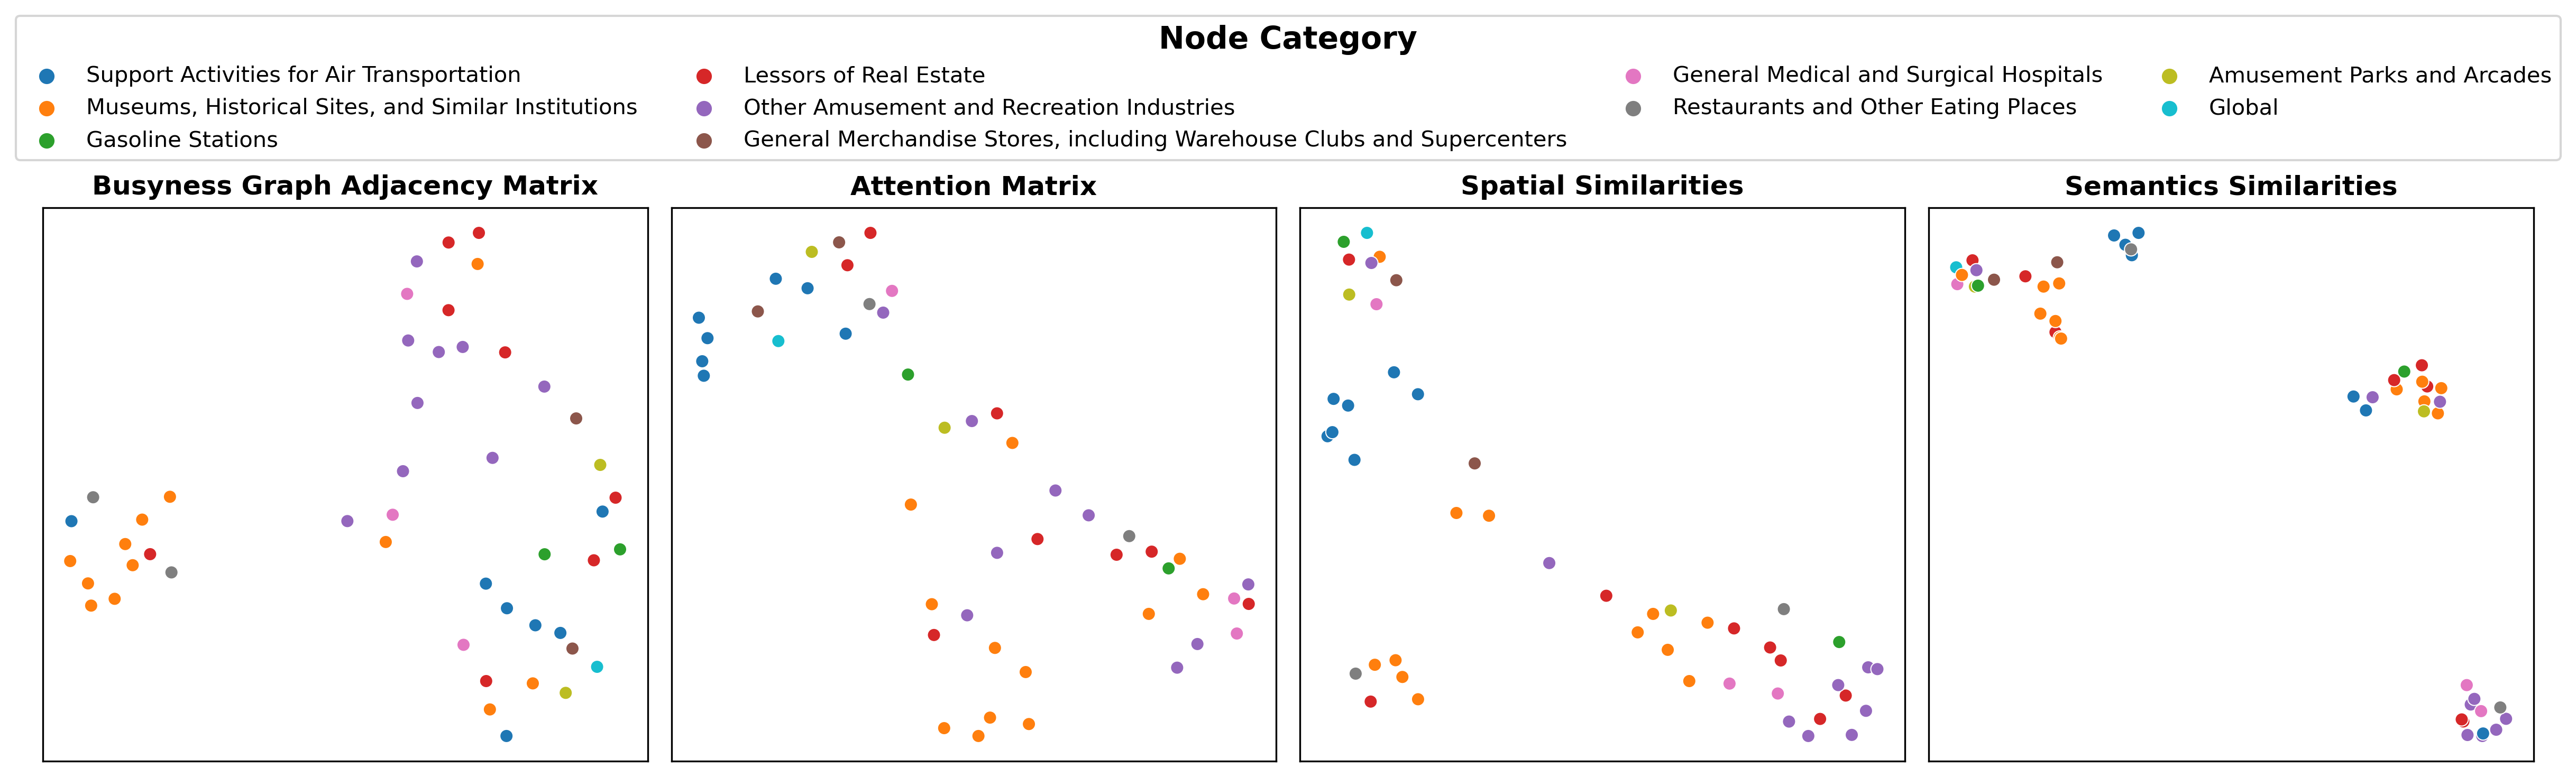

In [9]:
titles = ['Busyness Graph Adjacency Matrix', 'Attention Matrix', 'Spatial Similarities', 'Semantics Similarities']

# Assuming you have the four embedding matrices
embedding_matrices = [
    gnn_embeddings_orig_adj,
    gnn_embeddings_att_adj,
    gnn_embeddings_dist_adj,
    gnn_embeddings_semantics_adj
]

# Assuming you have a DataFrame df with the corresponding categories for each embedding matrix

fig, axes = plt.subplots(1, len(embedding_matrices), figsize=(16, 4), dpi=300)

# sns.set_palette("colorblind")

for i, embedding_matrix in enumerate(embedding_matrices):
    reducer = umap.UMAP(n_neighbors=13, metric='cosine', random_state=42)
    embeddings_umap = reducer.fit_transform(embedding_matrix)

    df_umap = pd.DataFrame(embeddings_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    df_umap['top_category'] = df['top_category']

    ax = axes[i]
    sns.scatterplot(data=df_umap, x='UMAP Dimension 1', y='UMAP Dimension 2', hue='top_category', ax=ax)
    ax.set_title(f'{titles[i]}', fontweight='bold')
    # ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    # ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove()

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Add grid
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # Get the minimum and maximum values for both dimensions
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Set the same scale for x and y axes
    # ax.set_xlim(min(x_min, y_min), max(x_max, y_max))
    # ax.set_ylim(min(x_min, y_min), max(x_max, y_max))

# Get the handles and labels from the last plot to create a single legend
handles, labels = ax.get_legend_handles_labels()

# Create the legend at the top of the figure
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.23), ncol=len(embedding_matrices))
legend.set_title('Node Category', prop={'weight': 'bold', 'size': 14})

# sns.despine()
plt.tight_layout()
plt.savefig('gnn_embedding_viz_umap.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

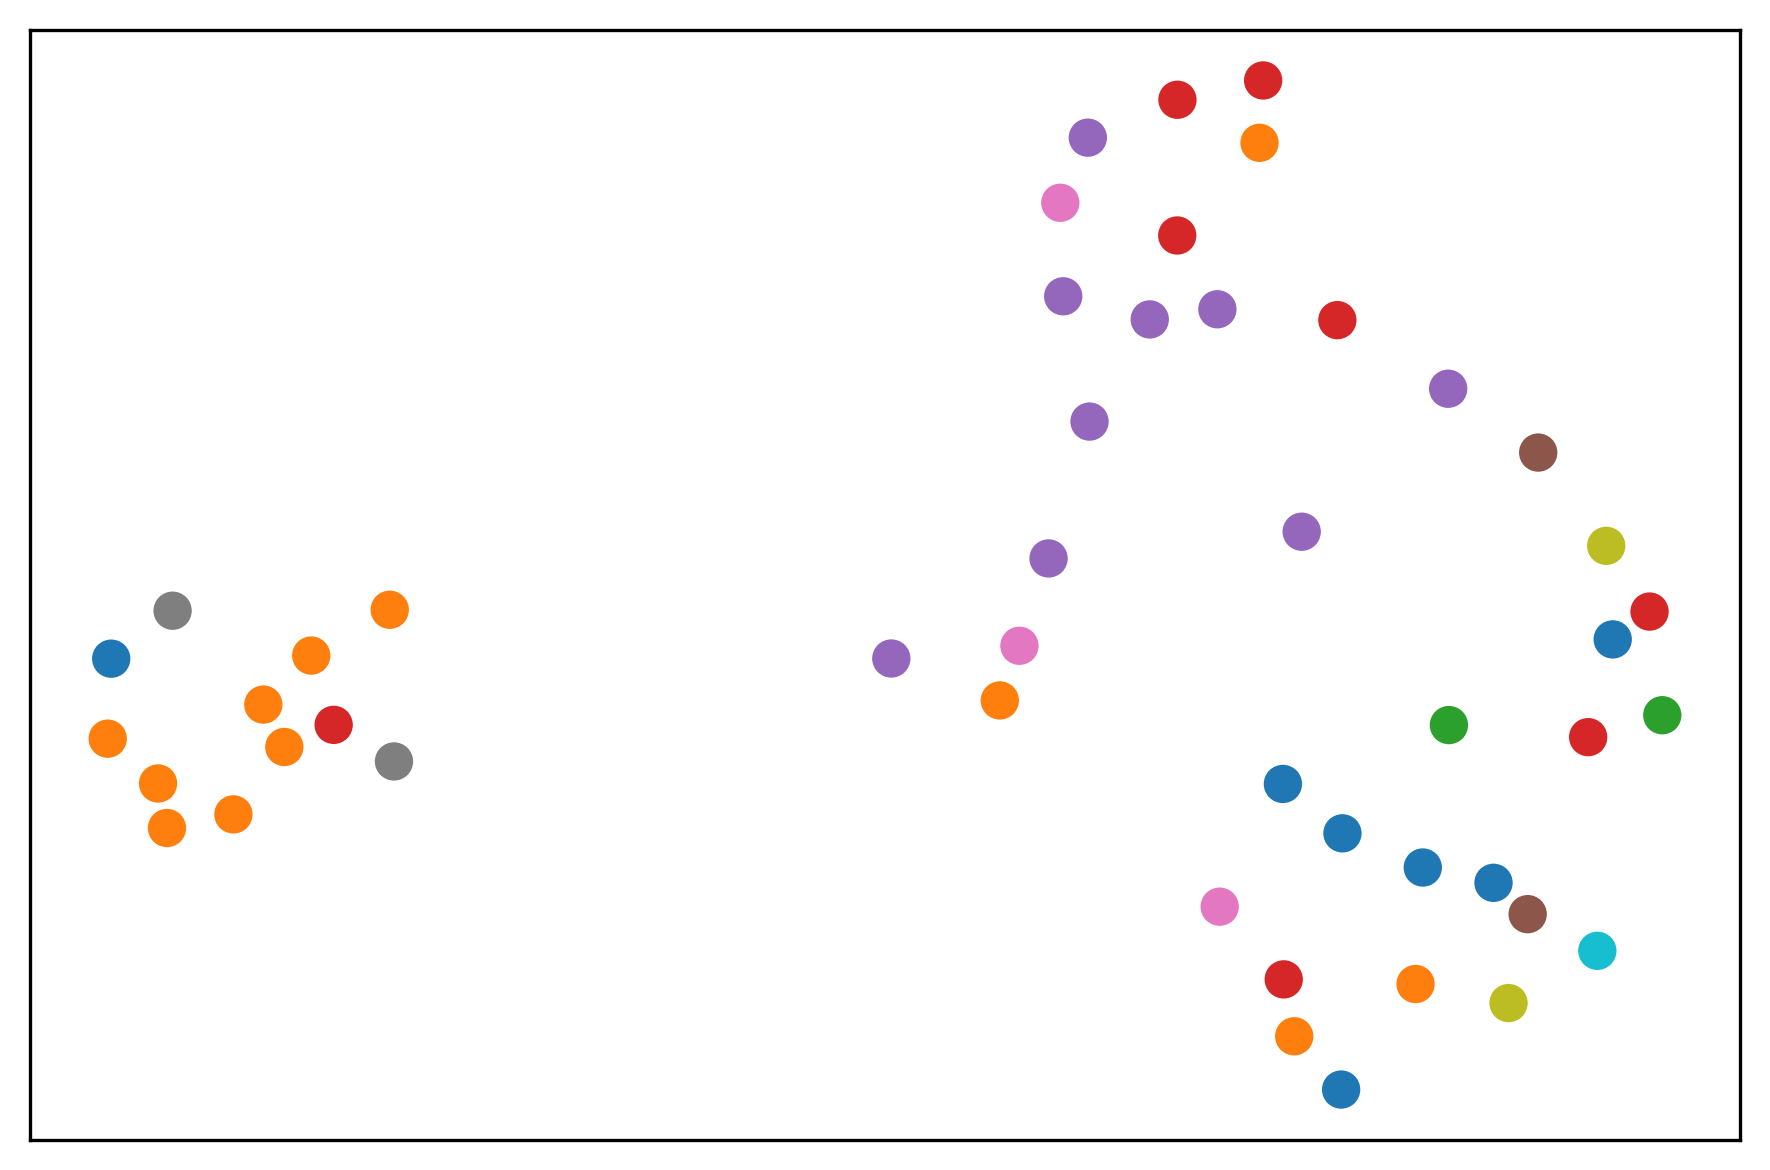

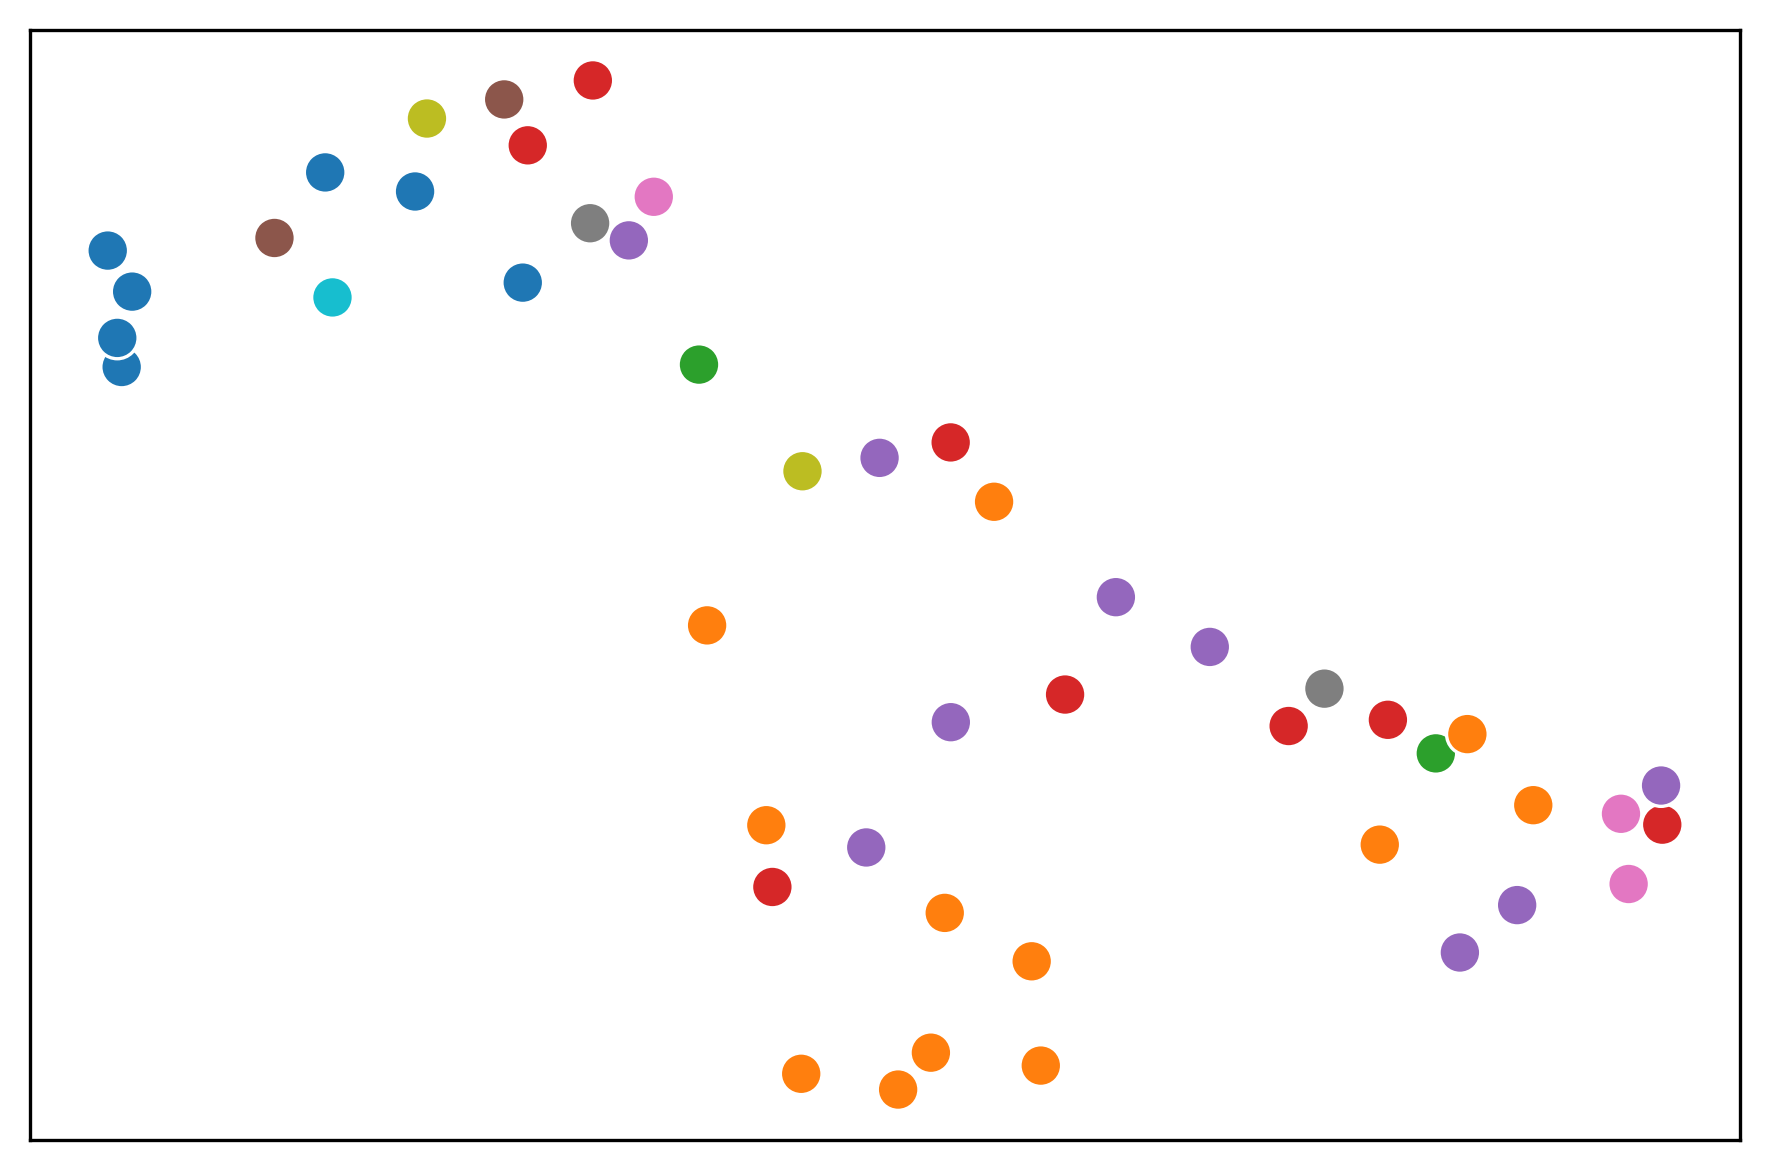

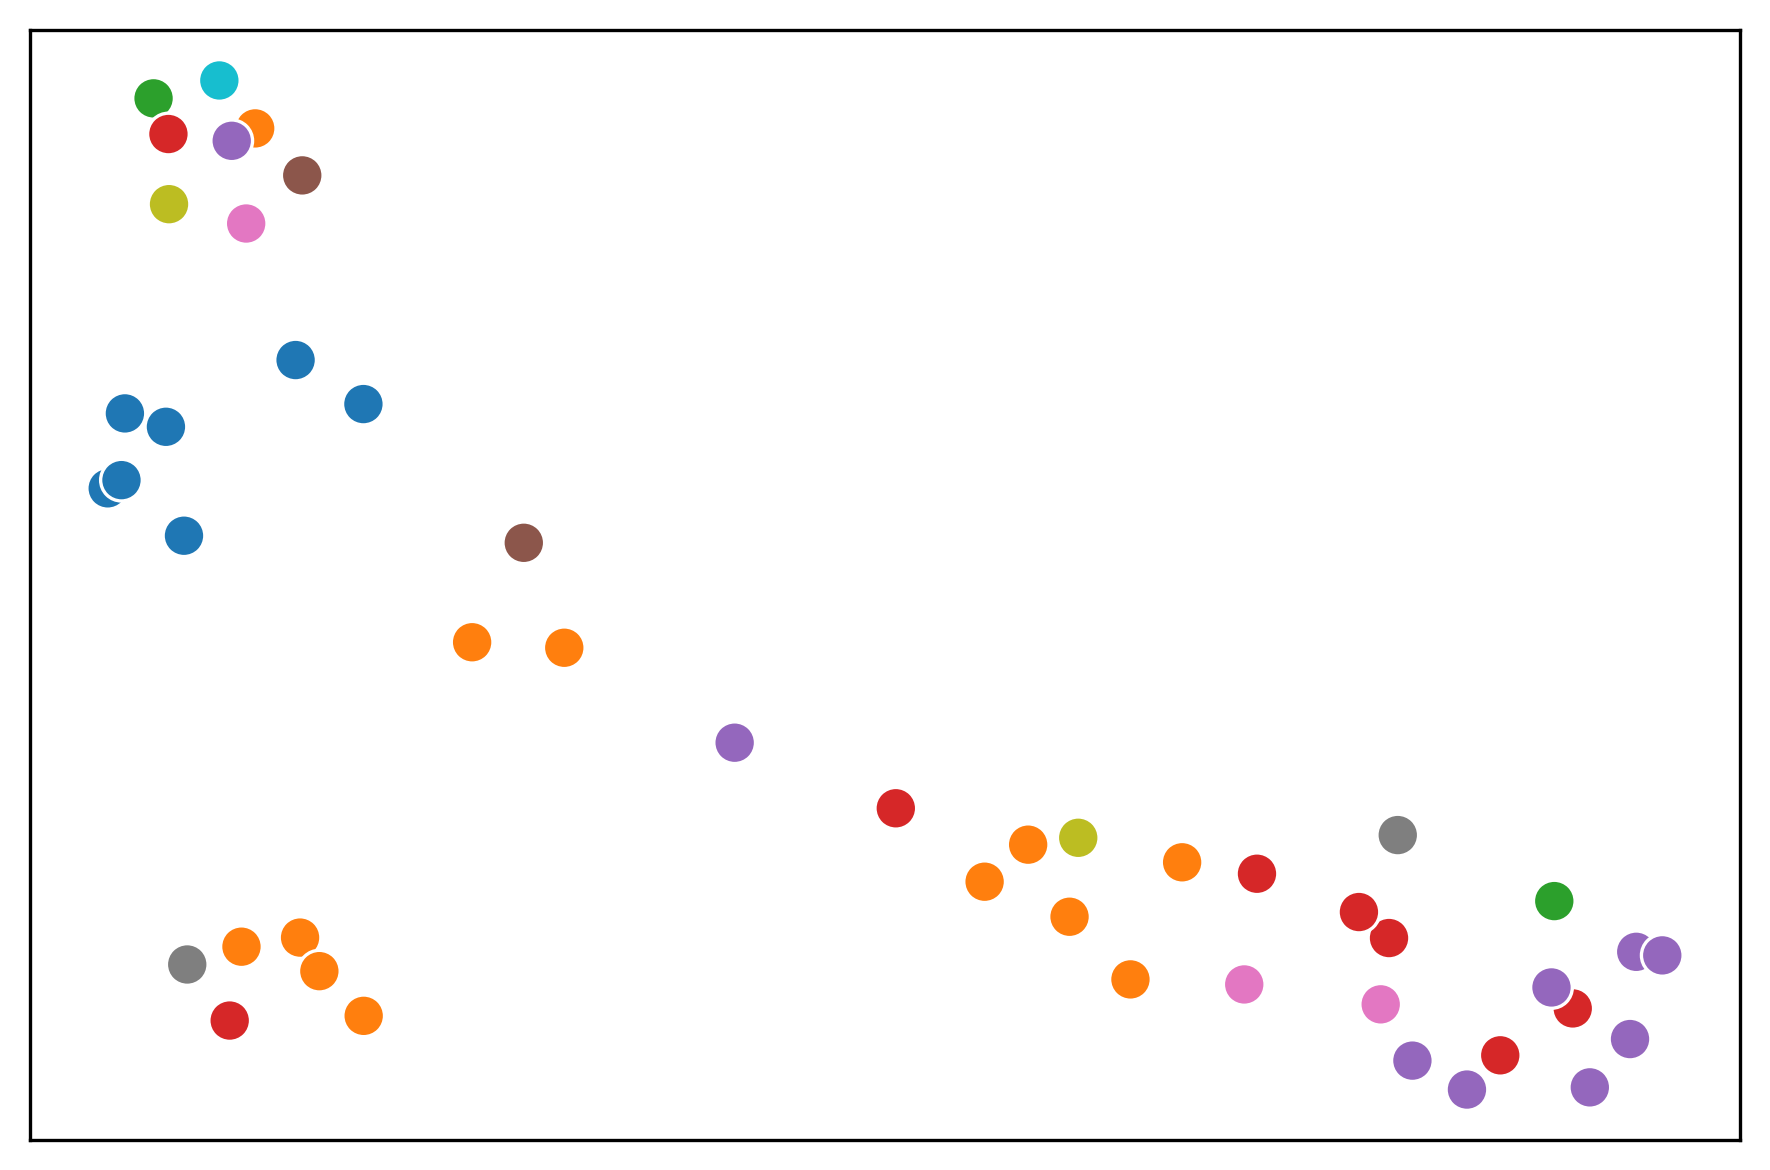

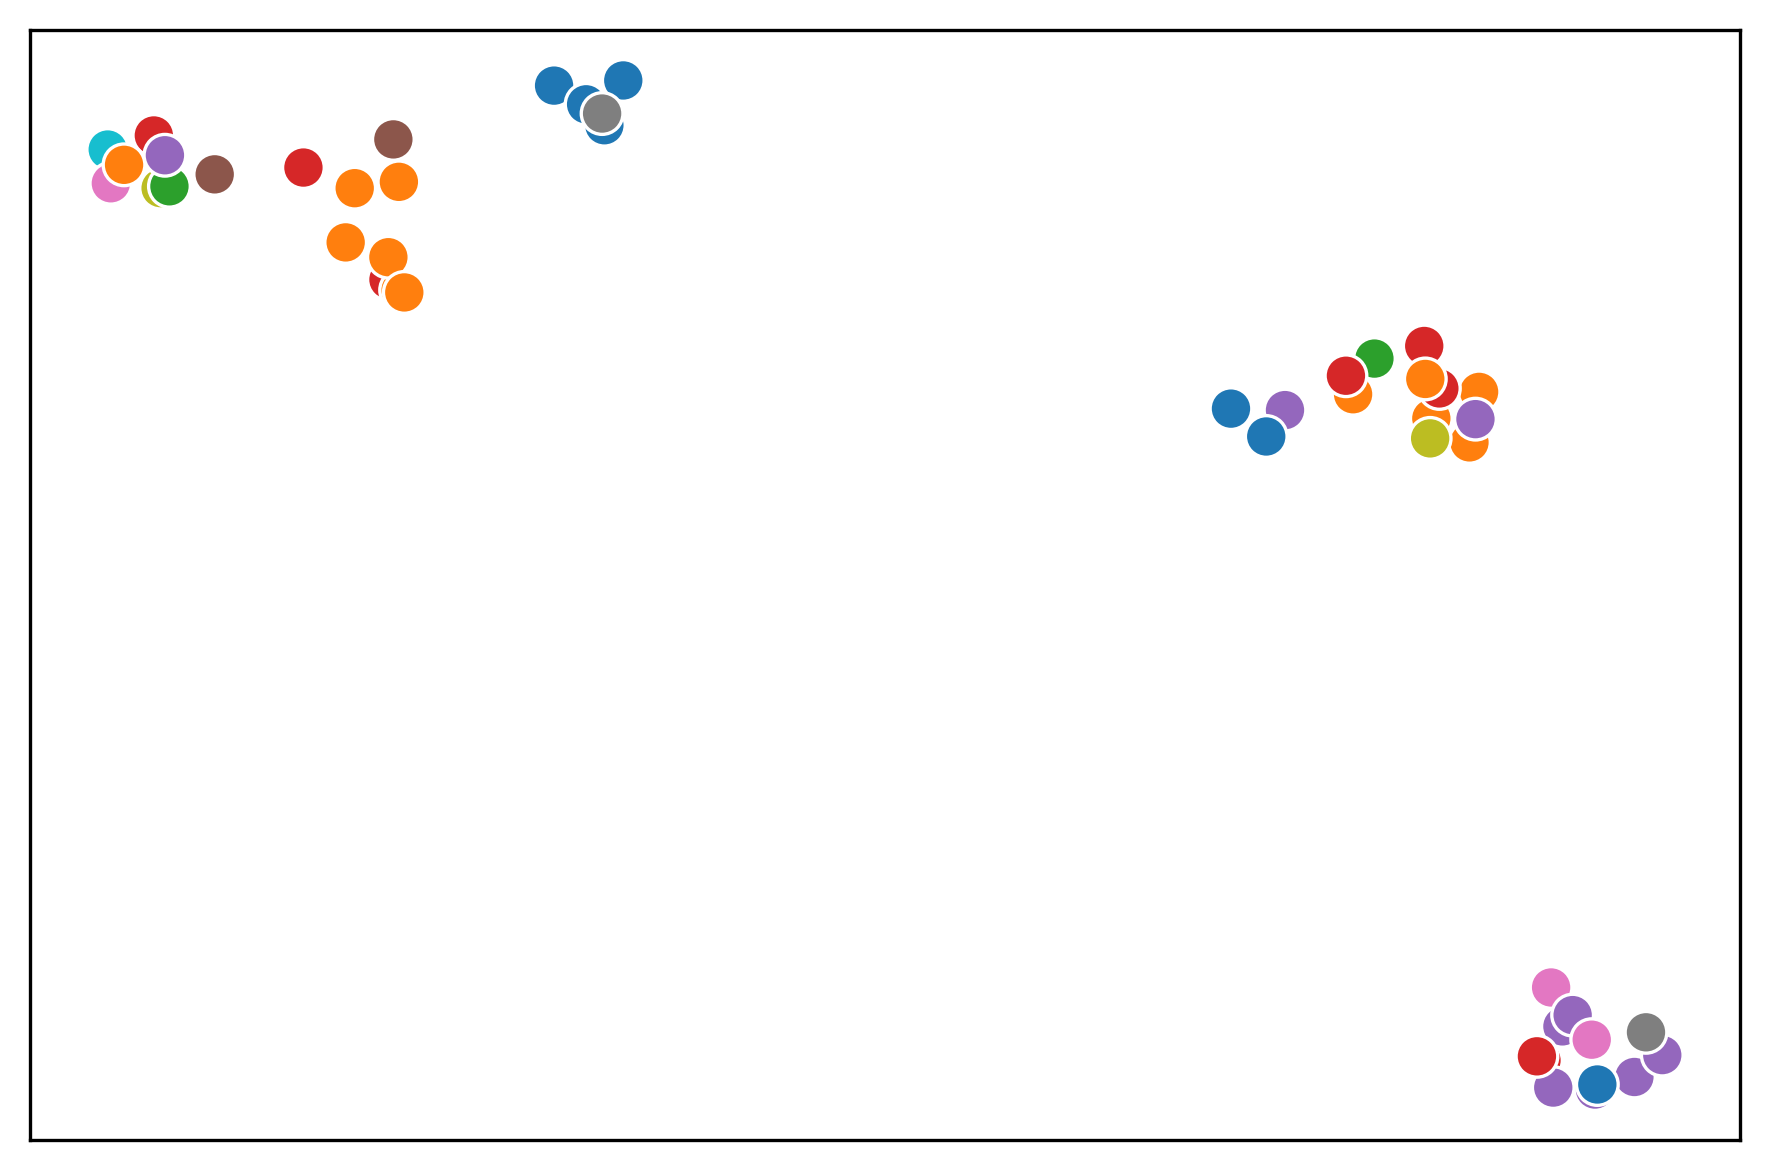

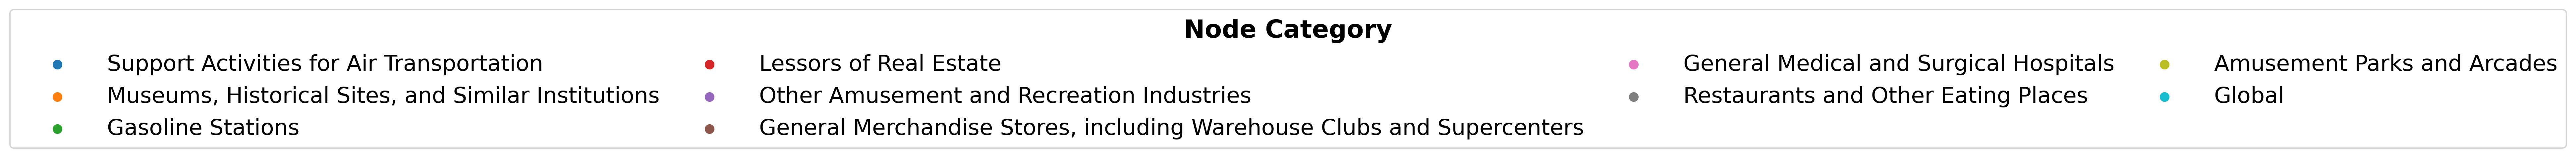

In [10]:
subplot_titles = ['bysgnn_adjacency', 'attention_matrix', 'spatial_sim', 'semantics_sim']

embedding_matrices = [
    gnn_embeddings_orig_adj,
    gnn_embeddings_att_adj,
    gnn_embeddings_dist_adj,
    gnn_embeddings_semantics_adj
]

# Save the subfigures separately
for i, embedding_matrix in enumerate(embedding_matrices):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
    
    reducer = umap.UMAP(n_neighbors=13, metric='cosine', random_state=42)
    embeddings_umap = reducer.fit_transform(embedding_matrix)
    
    df_umap = pd.DataFrame(embeddings_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    df_umap['top_category'] = df['top_category']
    
    sns.scatterplot(data=df_umap, x='UMAP Dimension 1', y='UMAP Dimension 2', hue='top_category', ax=ax, s=100)
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.savefig(f'img/embedding_viz_{subplot_titles[i]}.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)
    # plt.close()

# Save the legend separately
fig_legend = plt.figure(figsize=(6, 1), dpi=300)
legend = fig_legend.legend(handles, labels, loc='center', ncol=len(embedding_matrices), fontsize=16, handlelength=3.5, handletextpad=0.5, columnspacing=0.5)
legend.set_title('Node Category', prop={'weight': 'bold', 'size': 18})
plt.axis('off')
plt.tight_layout()
plt.savefig('img/embedding_legend.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)
# plt.close()

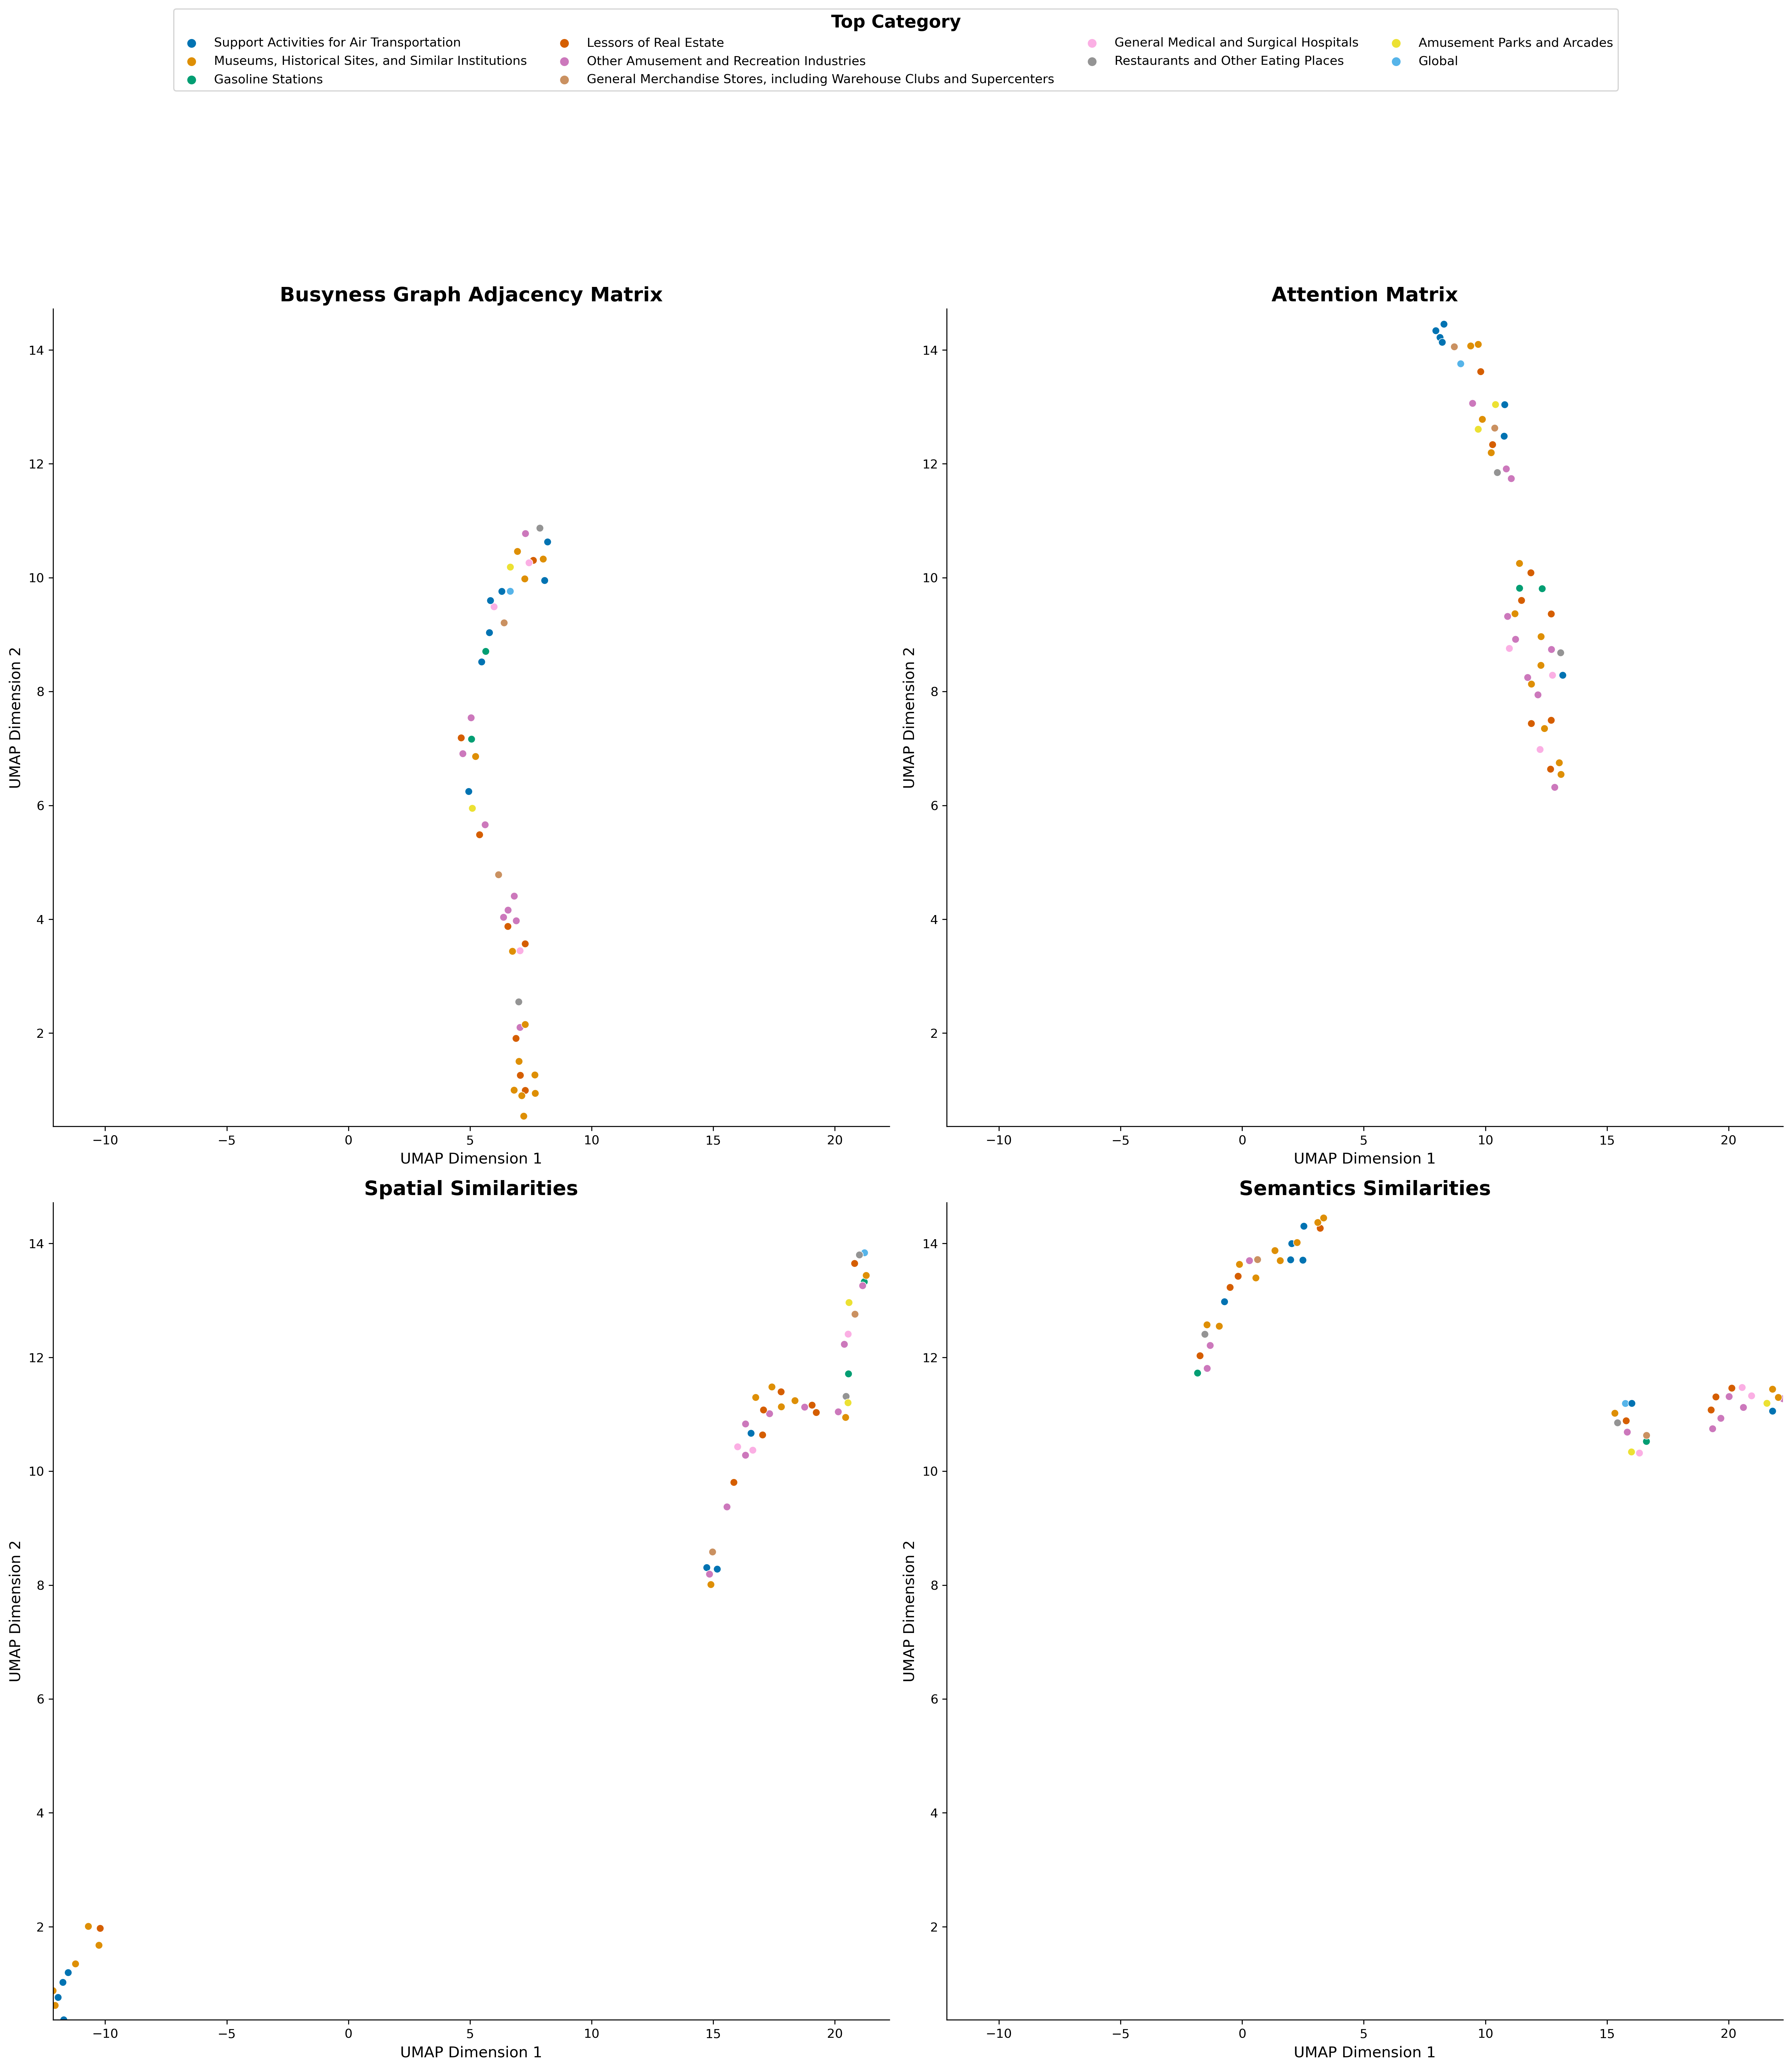

In [11]:
# Assuming you have the four embedding matrices
embedding_matrices = [
    gnn_embeddings_orig_adj,
    gnn_embeddings_att_adj,
    gnn_embeddings_dist_adj,
    gnn_embeddings_semantics_adj
]

# Assuming you have a DataFrame df with the corresponding categories for each embedding matrix
df_umap = pd.DataFrame(columns=['UMAP Dimension 1', 'UMAP Dimension 2', 'top_category'])

fig, axes = plt.subplots(2, len(embedding_matrices)//2, figsize=(20, 20), dpi=300)

sns.set_palette("colorblind")

# Calculate the overall minimum and maximum values for both dimensions
x_min = float('inf')
x_max = float('-inf')
y_min = float('inf')
y_max = float('-inf')

for i, embedding_matrix in enumerate(embedding_matrices):
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.15, random_state=117)
    embeddings_umap = reducer.fit_transform(embedding_matrix)

    df_umap_subset = pd.DataFrame(embeddings_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    df_umap_subset['top_category'] = df['top_category']

    df_umap = pd.concat([df_umap, df_umap_subset], ignore_index=True)

    x_min = min(x_min, embeddings_umap[:, 0].min())
    x_max = max(x_max, embeddings_umap[:, 0].max())
    y_min = min(y_min, embeddings_umap[:, 1].min())
    y_max = max(y_max, embeddings_umap[:, 1].max())

    ax = axes[i//2][i%2]
    sns.scatterplot(data=df_umap_subset, x='UMAP Dimension 1', y='UMAP Dimension 2', hue='top_category', ax=ax)
    ax.set_title(f'{titles[i]}', fontweight='bold', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax.set_ylabel('UMAP Dimension 2', fontsize=12)
    ax.legend().remove()

for row in axes:
    for ax in row:
        # Set the same limits for x and y axes across all subplots
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

# Get the handles and labels from the last plot to create a single legend
handles, labels = ax.get_legend_handles_labels()

# Create the legend at the top of the figure
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(embedding_matrices))
legend.set_title('Top Category', prop={'weight': 'bold', 'size': 14})

sns.despine()
plt.tight_layout()
plt.savefig('gnn_embedding_viz_umap.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' 

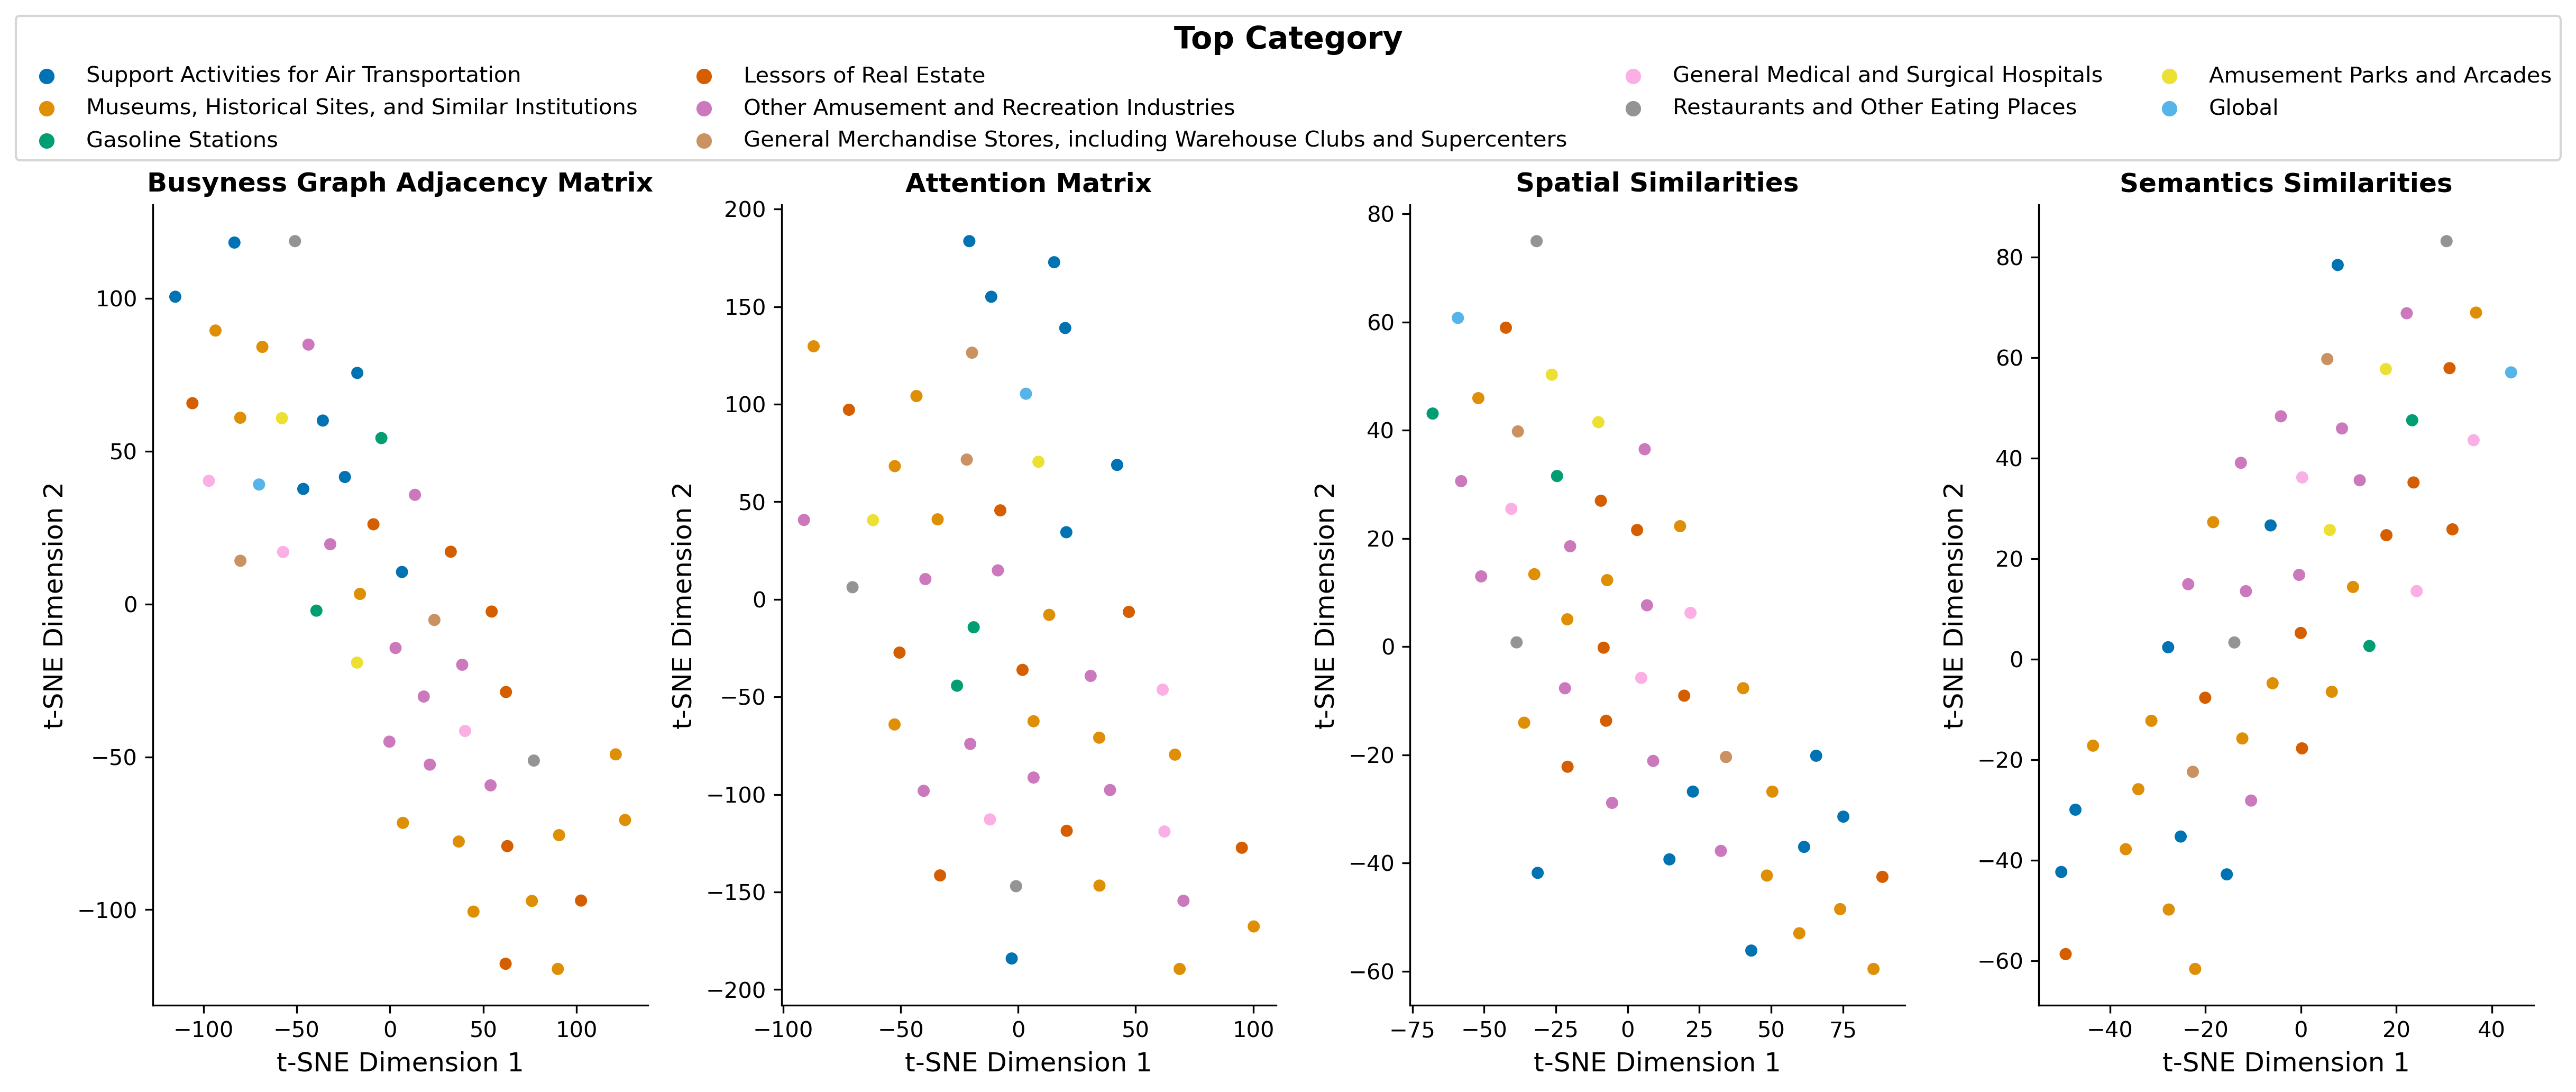

In [12]:
titles = ['Busyness Graph Adjacency Matrix', 'Attention Matrix', 'Spatial Similarities', 'Semantics Similarities']
# Assuming you have the four embedding matrices
embedding_matrices = [
    gnn_embeddings_orig_adj,
    gnn_embeddings_att_adj,
    gnn_embeddings_dist_adj,
    gnn_embeddings_semantics_adj
]

# Assuming you have a DataFrame df with the corresponding categories for each embedding matrix

fig, axes = plt.subplots(1, len(embedding_matrices), figsize=(16, 6), dpi=300)

sns.set_palette("colorblind")

for i, embedding_matrix in enumerate(embedding_matrices):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embedding_matrix)

    df_tsne = pd.DataFrame(embeddings_tsne, columns=['t-SNE Dimension 1', 't-SNE Dimension 2'])
    df_tsne['top_category'] = df['top_category']

    ax = axes[i]
    sns.scatterplot(data=df_tsne, x='t-SNE Dimension 1', y='t-SNE Dimension 2', hue='top_category', ax=ax)
    ax.set_title(f'{titles[i]}', fontweight='bold')
    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.legend().remove()

# Get the handles and labels from the last plot to create a single legend
handles, labels = ax.get_legend_handles_labels()

# Create the legend at the top of the figure
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(embedding_matrices))
legend.set_title('Top Category', prop={'weight': 'bold', 'size': 14})

sns.despine()
plt.tight_layout()
plt.savefig('gnn_embedding_viz_tsne.png', dpi=300, bbox_inches='tight', transparent=True)

### Better visualization

In [33]:
from sklearn.cluster import KMeans

def cluster_embeds(embeddings, num_clusters):
    reducer = umap.UMAP(n_neighbors=13, metric='cosine', random_state=42)
    embeddings_umap = reducer.fit_transform(embeddings)

    df_umap = pd.DataFrame(embeddings_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    
    # Initialize the K-means algorithm with the desired number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the algorithm to your UMAP embeddings
    kmeans.fit(df_umap)

    # Get the cluster labels for each data point
    cluster_labels = kmeans.labels_

    # Add the cluster labels to your DataFrame
    df_umap['cluster'] = cluster_labels
    return df_umap


def plot_clustered_embeds(df_umap, save_path=None):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
    sns.scatterplot(data=df_umap, x='UMAP Dimension 1', y='UMAP Dimension 2', ax=ax, hue='cluster', s=100, palette='Set1')
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight', transparent=True)
        

def plot_embeds(df_umap, save_path=None, annotate_row_ind=False, pdf=True):
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    marker_shapes = ['o', '^', 's', 'D']
    # Plot the scatter points with color and shape mapping
    sns.scatterplot(
        data=df_umap,
        x='UMAP Dimension 1',
        y='UMAP Dimension 2',
        hue='semantics_cluster',
        style='dist_cluster',
        markers=marker_shapes,
        palette='Set1',
        ax=ax,
        s=150
    )
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend().remove()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if annotate_row_ind:
        for index, row in df_umap.iterrows():
            ax.annotate(index, (row['UMAP Dimension 1'], row['UMAP Dimension 2']+0.01), fontsize=12, ha='center', va='bottom')

    plt.tight_layout()
    if save_path and pdf:
        plt.savefig(f'{save_path}.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)
    elif save_path:
        plt.savefig(f'{save_path}.png', dpi=300, bbox_inches='tight', transparent=True)
        

def generate_reduced_embed_df(embeddings, df_dist, df_semantics):
    reducer = umap.UMAP(n_neighbors=13, metric='cosine', random_state=42)
    embeddings_umap = reducer.fit_transform(embeddings)
    df_umap = pd.DataFrame(embeddings_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    df_umap['dist_cluster'] = df_dist['cluster']
    df_umap['semantics_cluster'] = df_semantics['cluster']
    return df_umap

In [19]:
df_dist = cluster_embeds(gnn_embeddings_dist_adj, 2)
df_semantics = cluster_embeds(gnn_embeddings_semantics_adj, 5)
df_orig = generate_reduced_embed_df(gnn_embeddings_orig_adj, df_dist, df_semantics)
df_att = generate_reduced_embed_df(gnn_embeddings_att_adj, df_dist, df_semantics)
df_dist_full = generate_reduced_embed_df(gnn_embeddings_dist_adj, df_dist, df_semantics)
df_semantics_full = generate_reduced_embed_df(gnn_embeddings_semantics_adj, df_dist, df_semantics)

/tmp/ipykernel_9098/2362169010.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
/tmp/ipykernel_9098/2362169010.py:44: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_9098/2362169010.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
/tmp/ipykernel_9098/2362169010.py:44: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(
/tmp

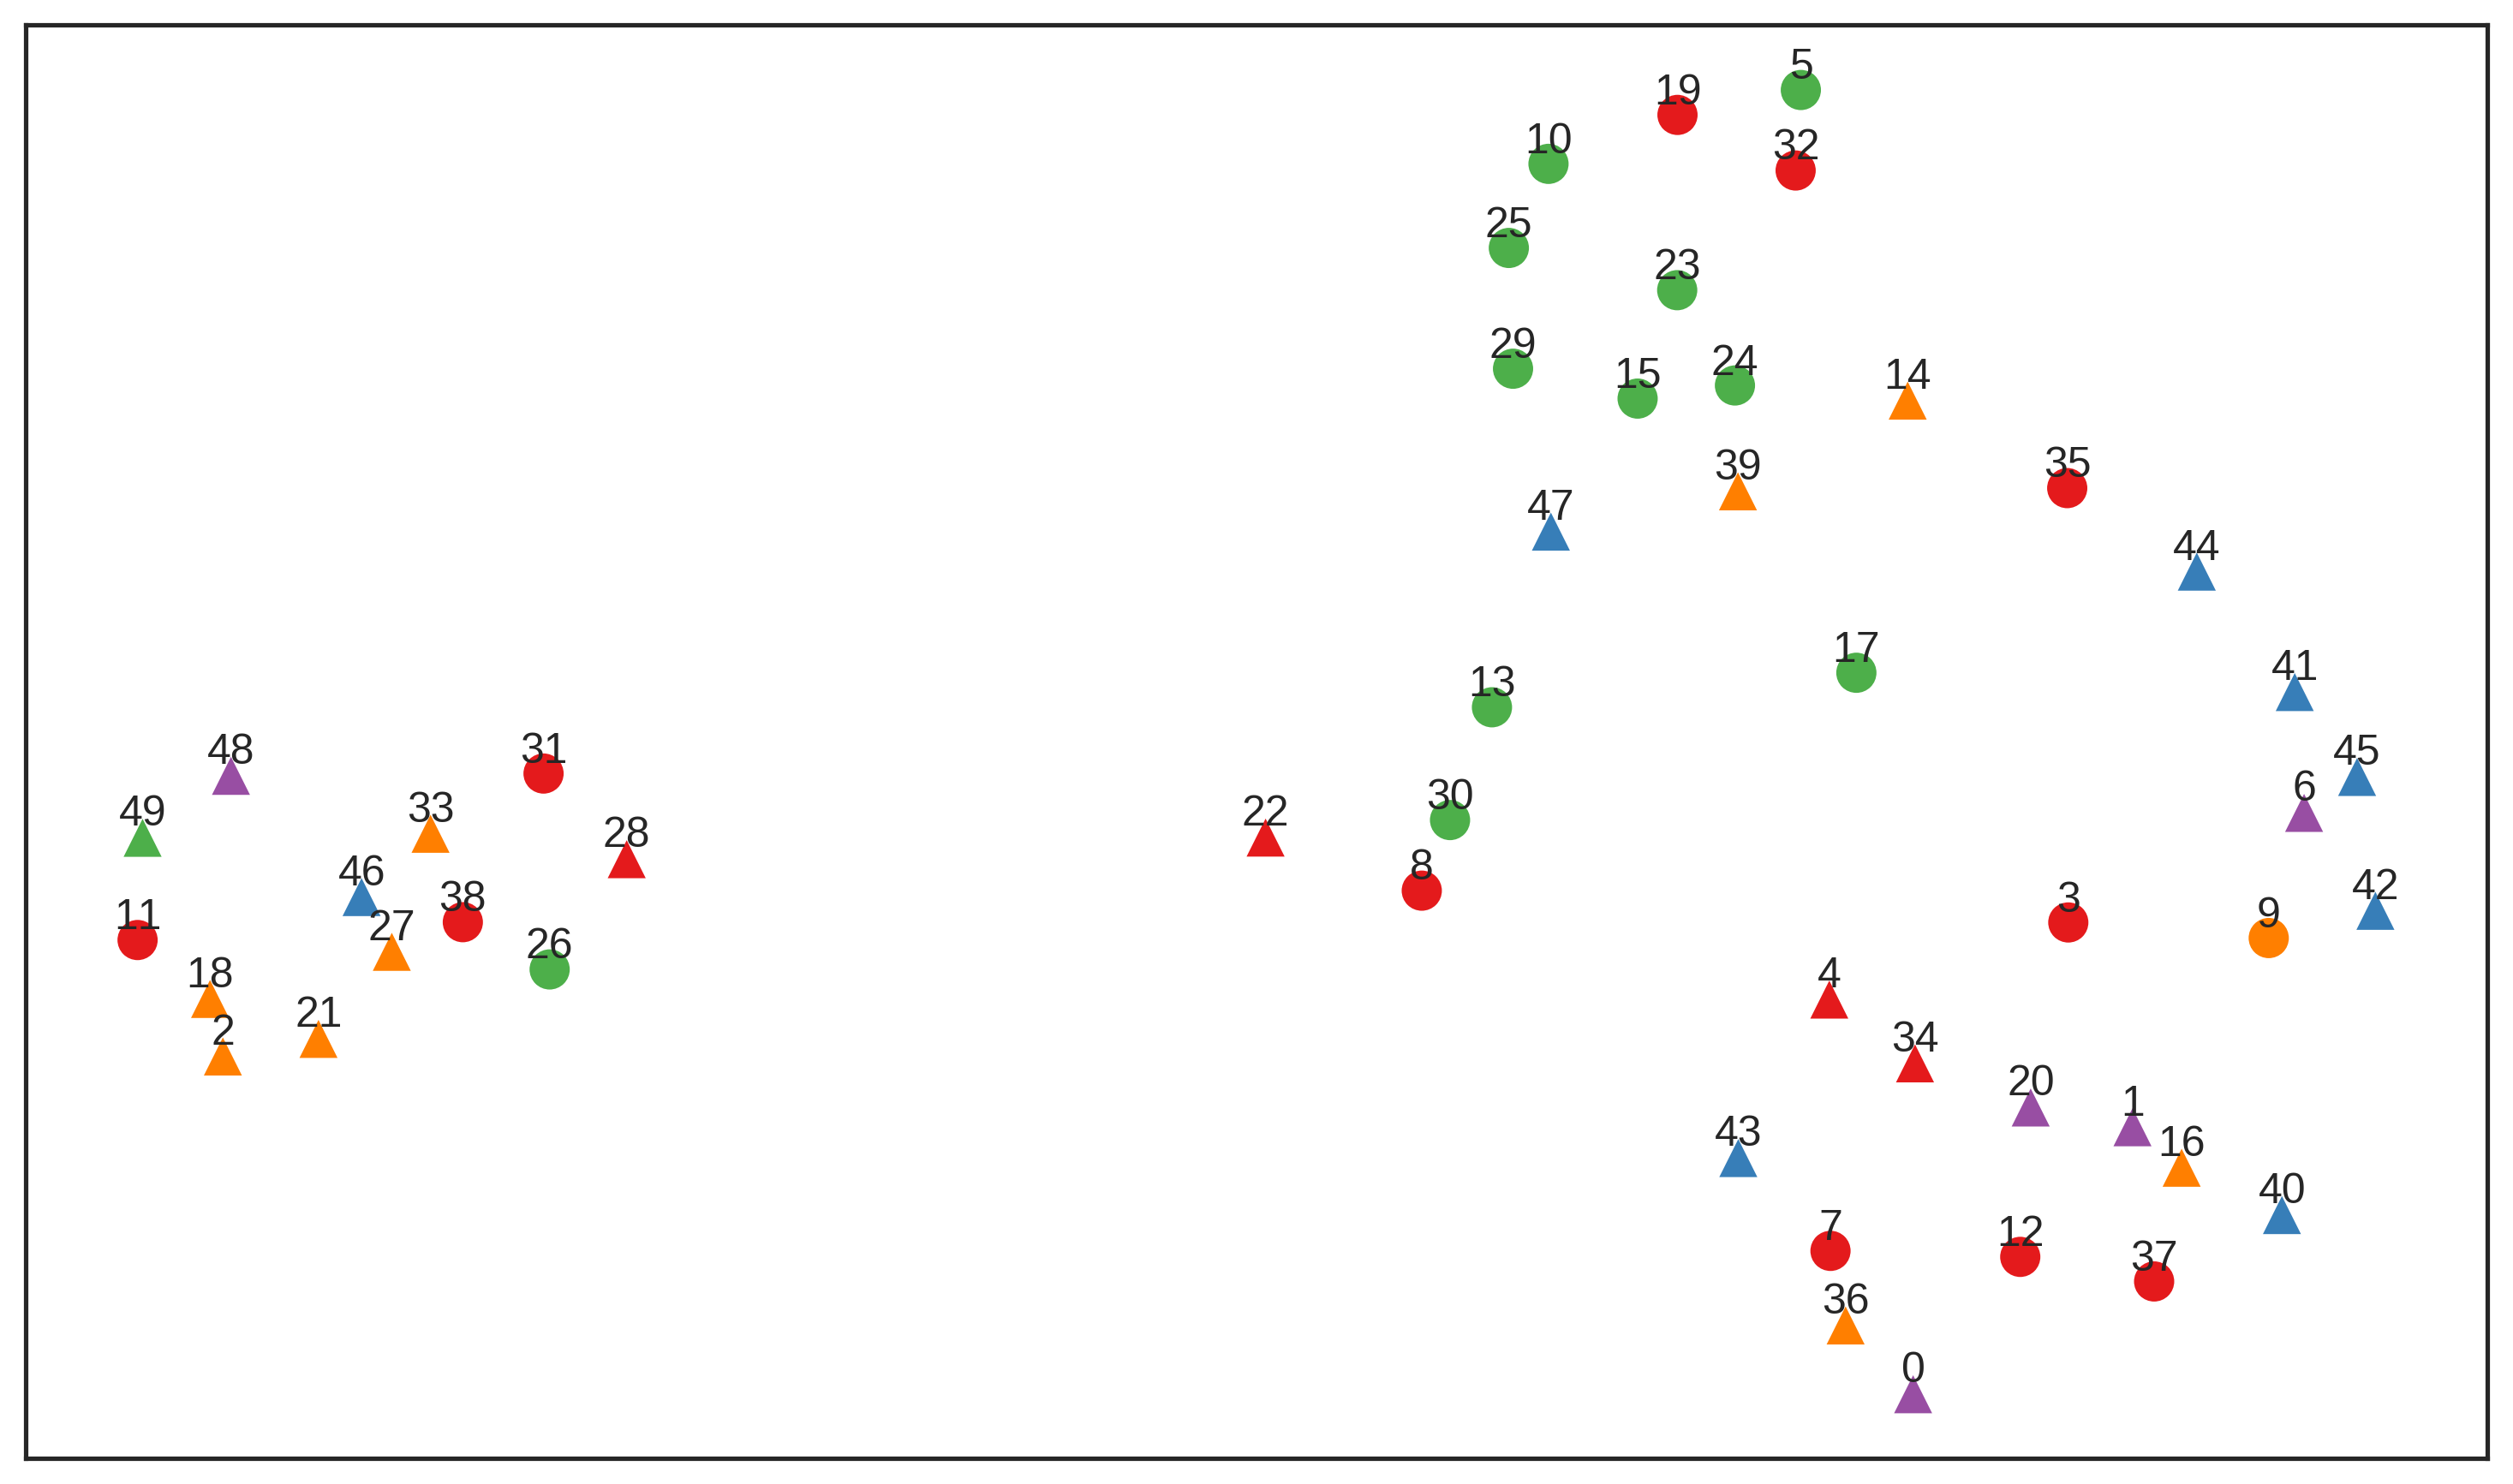

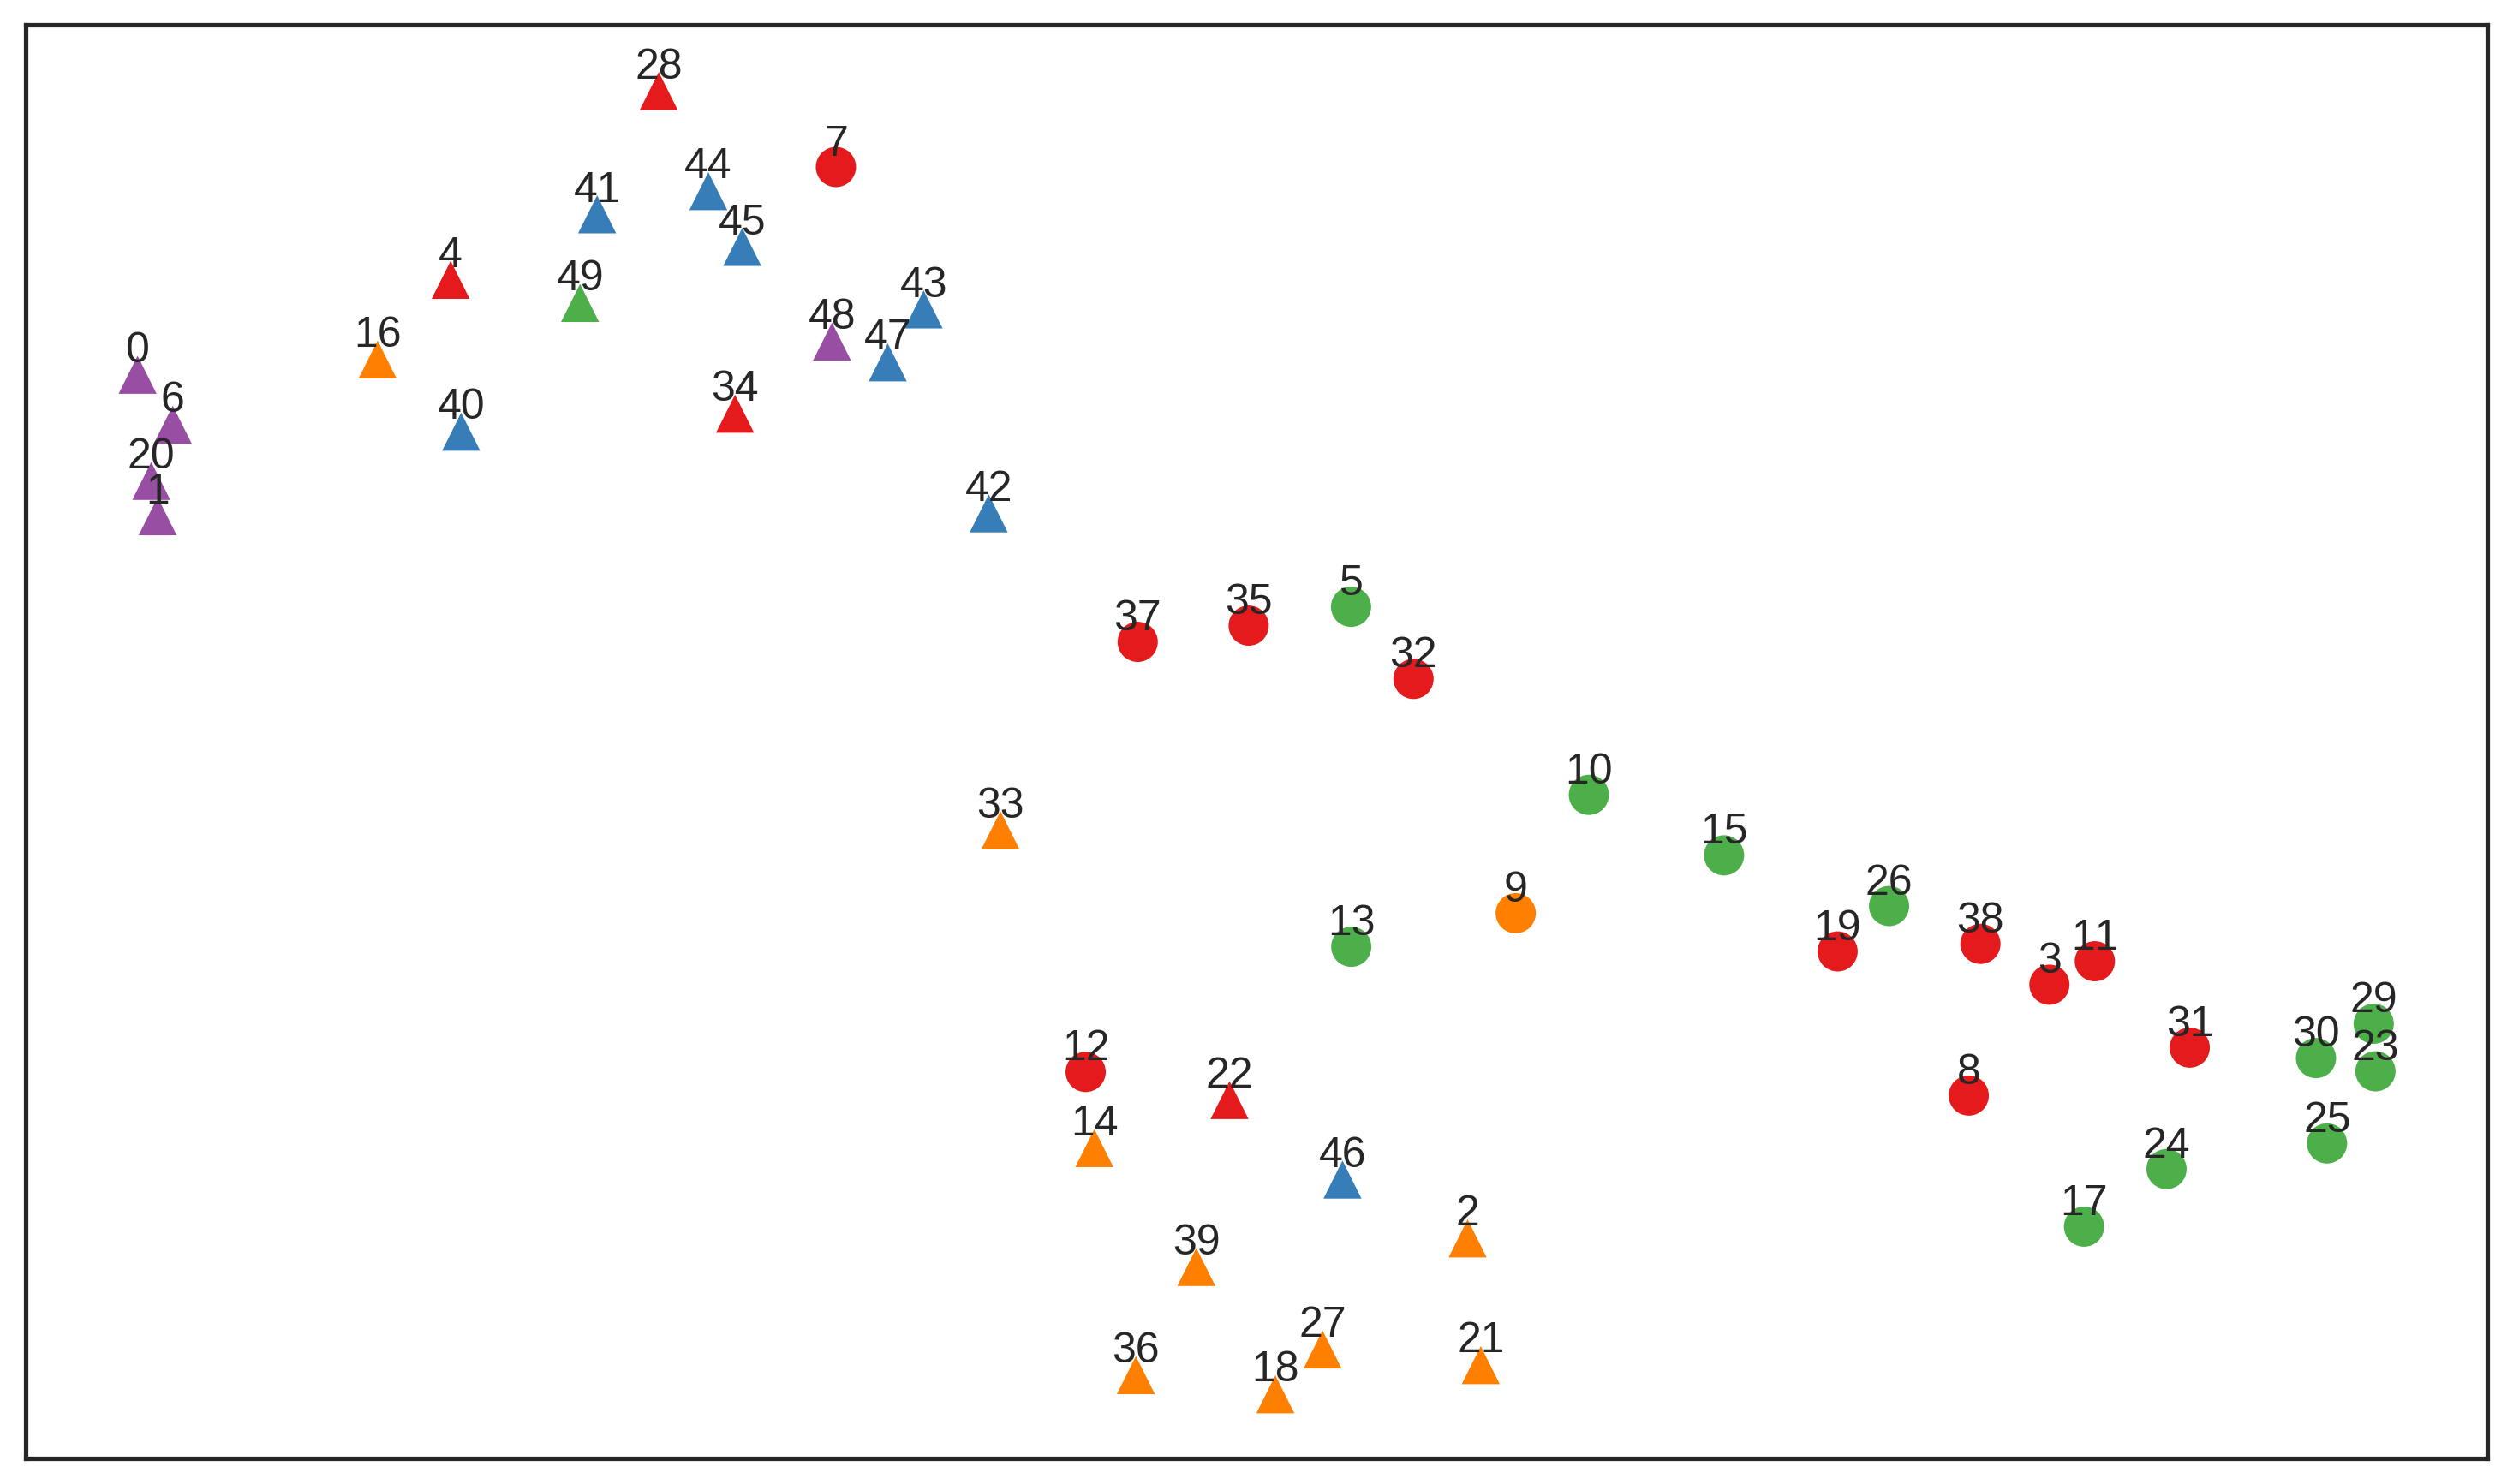

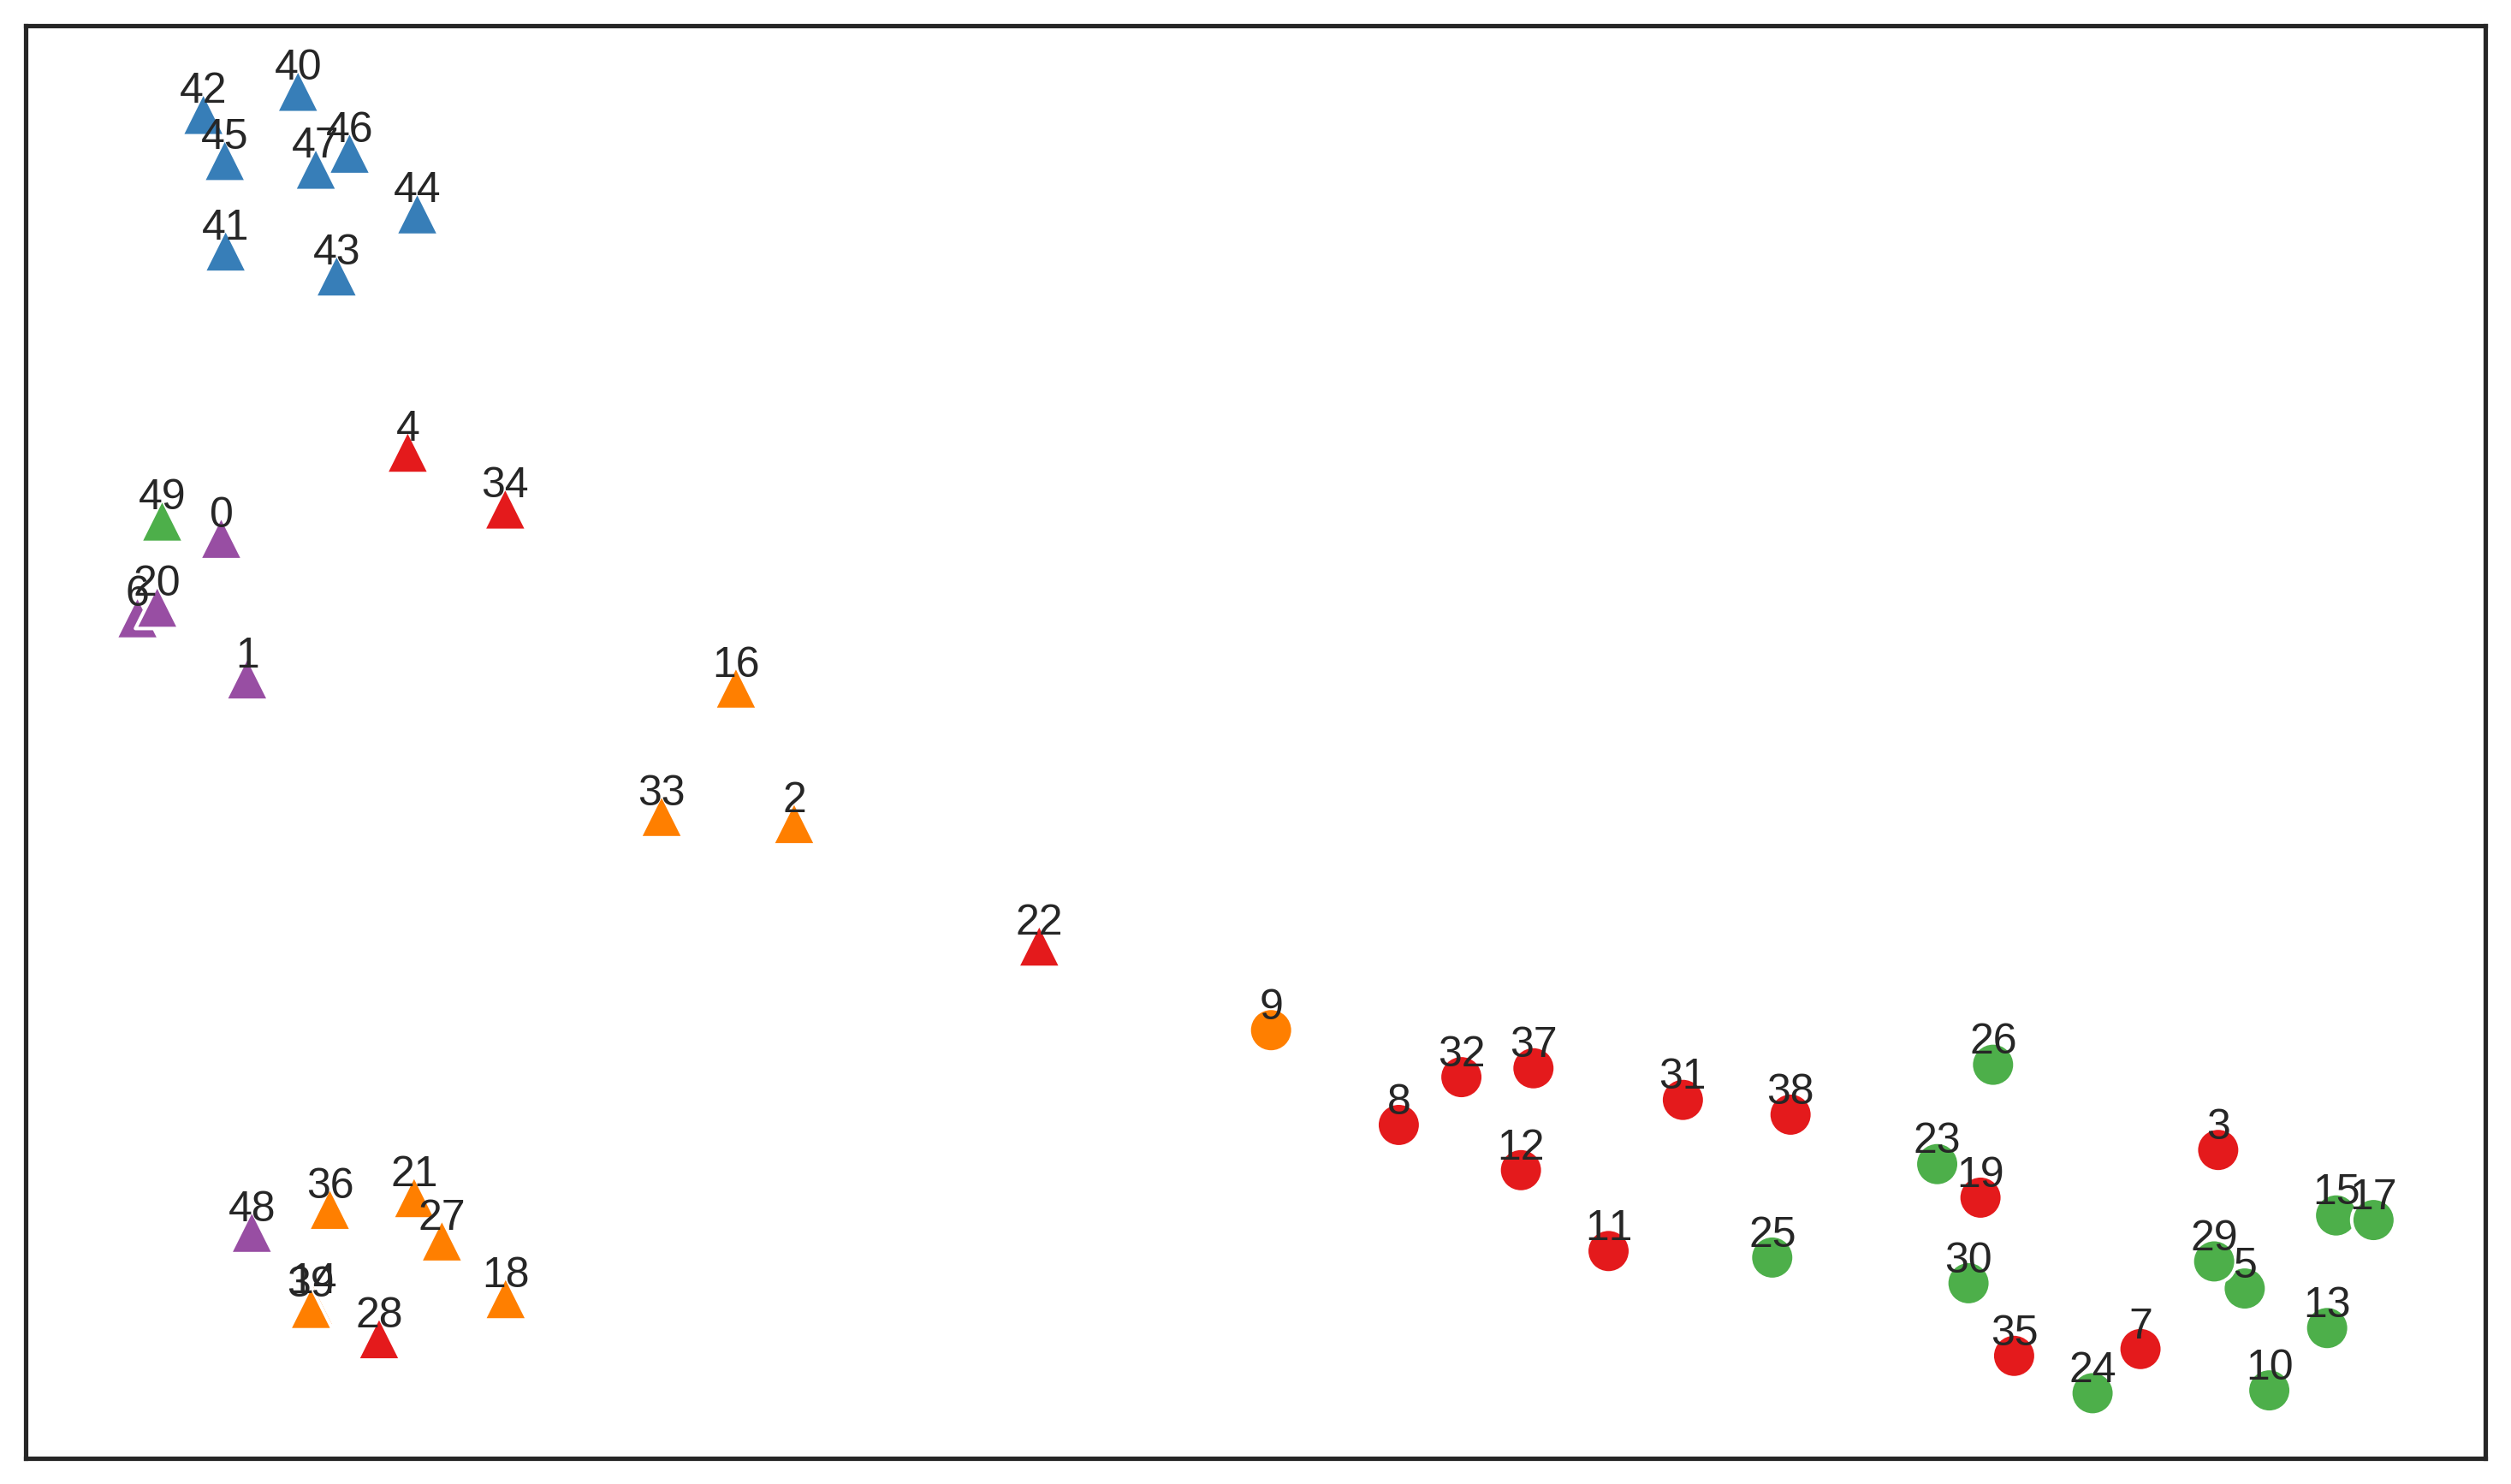

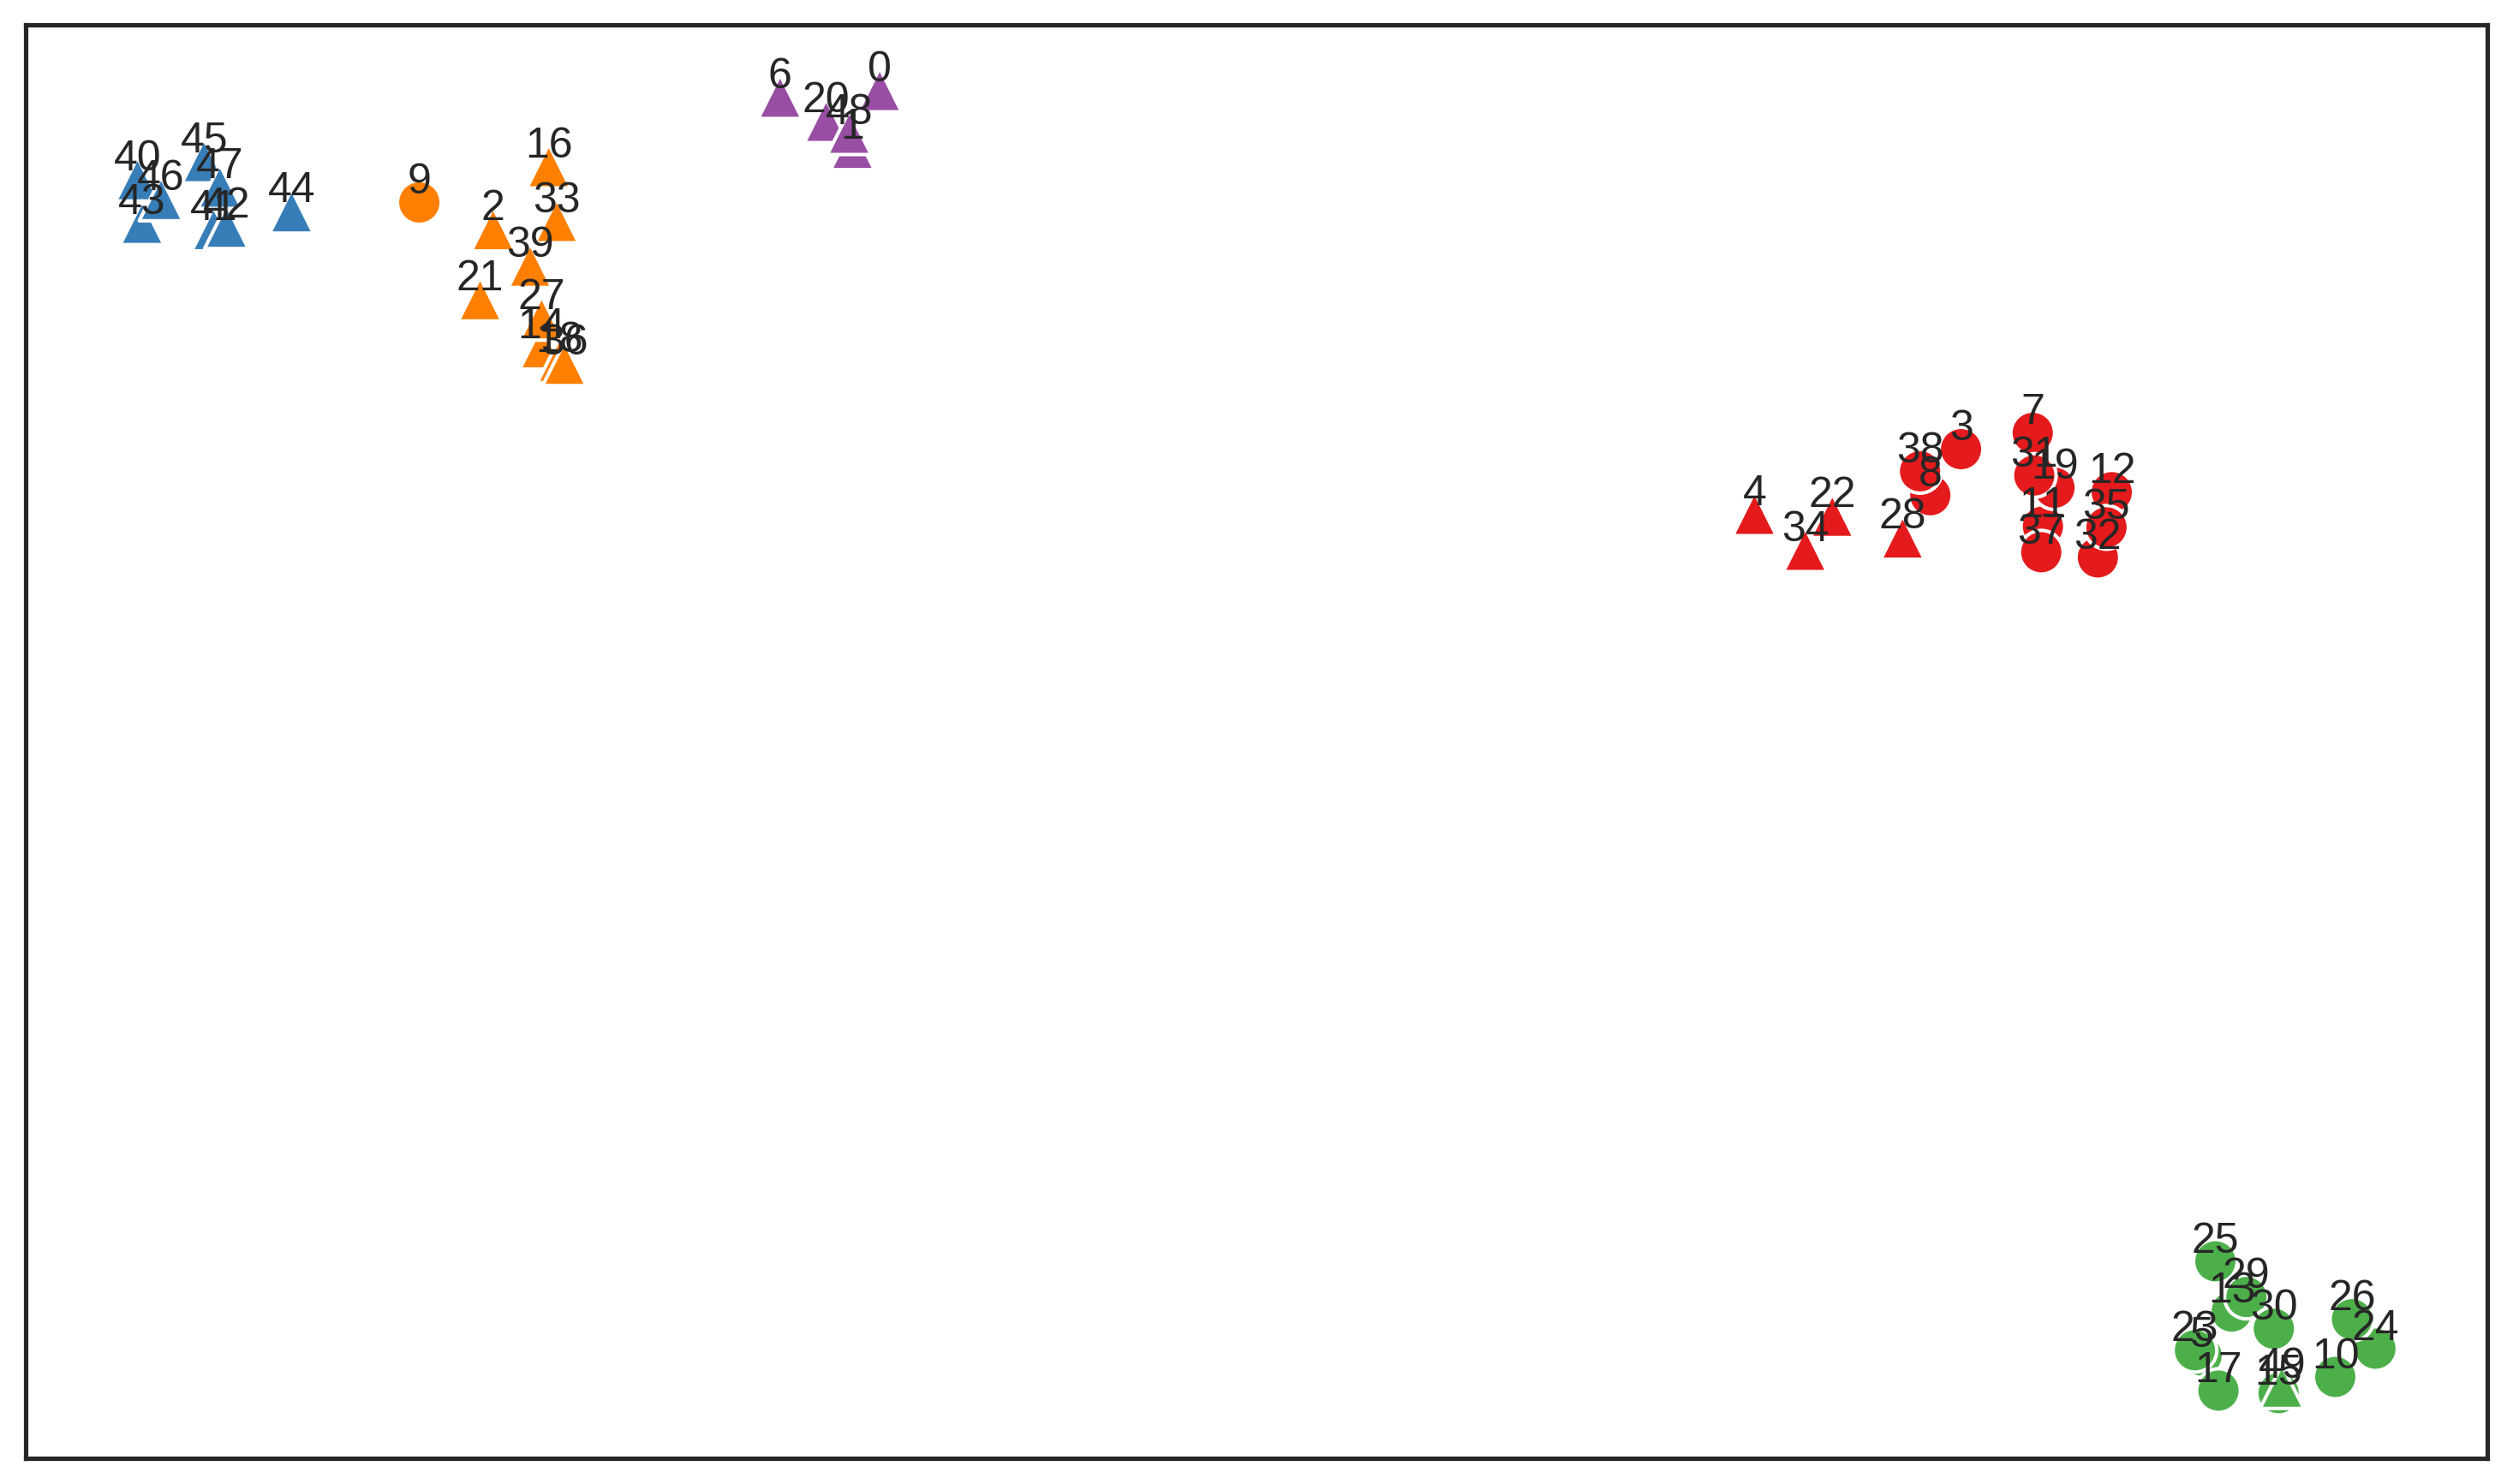

In [34]:
df_list = [df_orig, df_att, df_dist_full, df_semantics_full]
df_names = ['Busyness Graph Adjacency Matrix', 'Attention Matrix', 'Spatial Similarities', 'Semantics Similarities']
for i, df in enumerate(df_list):
    plot_embeds(df, save_path=f'img/embedding_viz_{df_names[i]}', annotate_row_ind=True, pdf=False)

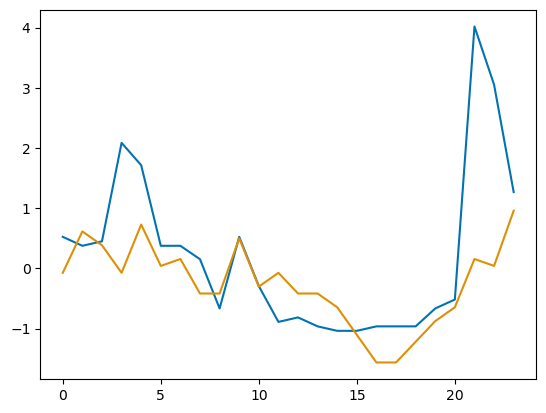

In [68]:
plt.plot(x.squeeze(0)[:, 33])
plt.plot(x.squeeze(0)[:, 38])

In [72]:
df.iloc[[33, 38]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
33,sg:5007bdb923c64c03951ac200b36bc6e6,"[182, 338, 349, 384, 330, 174, 137, 319, 342, ...","[0, 2, 0, 0, 1, 7, 6, 8, 8, 5, 4, 5, 3, 6, 52,...",154067,Cunningham Park,196 10 Union Turnpike,New York,NY,11364.0,US,NaN,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190.0,40.728028,-73.772224,NaN,"{ ""Mon"": [[""5:00"", ""24:00""]], ""Tue"": [[""5:00"",...",NaN
38,sg:832e1a49583a478a8f0f1dd554f76d85,"[271, 265, 321, 374, 363, 275, 229, 322, 388, ...","[9, 3, 3, 0, 3, 7, 8, 12, 10, 21, 15, 12, 10, ...",138301,Grand Central Station Holiday Market,42nd St And Lexington Ave,New York,NY,10017.0,US,NaN,NaN,NaN,Lessors of Real Estate,Malls,531120.0,40.751630,-73.976093,NaN,NaN,NaN
